# D&G Pricing Analyst Assessment - Code

In [1]:
# Packages Used

#baisc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#statistics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy.stats import kruskal


# 1. PRE PROCESSING

In [2]:
#Load Data

data = pd.read_csv('pricing_analyst_dataset.csv')
df = pd.DataFrame(data)
pd.options.display.max_columns = None
df

,offerdate,sold_premium,offered_premium,purchase_price,purchase_date,age,pricing_point,predictedconversionrate,plan_flag,plan_count,plansactive_lastyear_count,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,IsModel,sale_flag,base_rate,manufacturerbrandname_enc,itemcategoryname_enc,itemsupercategorycode_enc
0,17/03/2023,NaN,32.64,89.99,16/03/2023,1,@22%,0.15,0,0.0,0.0,0.0,0.0,0.00,-0.058824,Yes,0,34.68,56,35,14
1,01/03/2023,69.72,69.72,329.00,24/12/2022,67,@22%,0.81,1,5.0,8.0,2.0,4.0,347.12,-0.023529,Yes,1,71.40,123,34,3
2,12/04/2023,NaN,48.24,249.00,05/04/2023,7,@23%,0.08,0,0.0,0.0,0.0,0.0,0.00,0.210843,Yes,0,39.84,7,16,12
3,09/03/2023,NaN,91.92,746.42,09/03/2021,730,@23%,0.32,0,0.0,0.0,0.0,0.0,0.00,0.298305,Yes,0,70.80,107,36,4
4,18/03/2023,NaN,89.64,493.98,18/03/2023,0,@22%,0.25,1,1.0,1.0,0.0,0.0,0.00,0.299130,Yes,0,69.00,57,36,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8862,10/04/2023,NaN,69.72,275.00,08/04/2023,2,@23%,0.11,0,0.0,0.0,0.0,0.0,0.00,0.094162,Yes,0,63.72,7,37,4
8863,30/03/2023,69.72,69.72,262.14,23/03/2023,7,@22%,0.14,0,0.0,0.0,0.0,NaN,NaN,0.218029,Yes,1,57.24,74,34,3
8864,21/03/2023,NaN,48.12,280.00,21/03/2023,0,@22%,0.12,0,0.0,0.0,0.0,0.0,0.00,-0.012315,Yes,0,48.72,62,12,4
8865,10/03/2023,NaN,69.72,550.00,09/03/2023,1,@22%,0.31,1,1.0,2.0,1.0,NaN,NaN,0.249462,Yes,0,55.80,74,37,4


In [3]:
# check for null values and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8867 entries, 0 to 8866
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   offerdate                      8867 non-null   object 
 1   sold_premium                   1991 non-null   float64
 2   offered_premium                8867 non-null   float64
 3   purchase_price                 8866 non-null   float64
 4   purchase_date                  8867 non-null   object 
 5   age                            8867 non-null   object 
 6   pricing_point                  8867 non-null   object 
 7   predictedconversionrate        8867 non-null   float64
 8   plan_flag                      8867 non-null   int64  
 9   plan_count                     8826 non-null   float64
 10  plansactive_lastyear_count     8826 non-null   float64
 11  planscancelled_lastyear_count  8826 non-null   float64
 12  claims_count                   7718 non-null   f

Null values
1. Sold_premium (missing 6876) - Which has only values where we won the order. So, it should match with the no. of values in the    1s of Sale_flag --> Check that with query.
2. Purchase_Price (missing 1 value)
3. plan_count, plansactive_lastyear_count and planscancelled_lastyear_count (missing 41)
4. claims_count and claim_amount (missing 1149)

Data types
1. offerdate and purchase_date --> change it to datetime
2. age --> change it to int32
3. plan_count, plansactive_lastyear_count and planscancelled_lastyear_count --> change it to int32


In [4]:
df.columns.values

array(['offerdate', 'sold_premium', 'offered_premium', 'purchase_price',
       'purchase_date', 'age', 'pricing_point', 'predictedconversionrate',
       'plan_flag', 'plan_count', 'plansactive_lastyear_count',
       'planscancelled_lastyear_count', 'claims_count', 'claim_amount',
       'price_diff', 'IsModel', 'sale_flag', 'base_rate',
       'manufacturerbrandname_enc', 'itemcategoryname_enc',
       'itemsupercategorycode_enc'], dtype=object)

# 1.1 Handling data types
Make sure that the values/quality of the data remians good and unchanged, caution on NaNs and 0 etc...

In [5]:
# 1st changing the dates (offerdate and purchase_date) to datetime 

# Check the dtype and some values before we change
print(f"data type of offerdate is {df['offerdate'].dtype}")
print(df['offerdate'].value_counts().head(10))
print(f"NaN count: {df['offerdate'].isna().sum()}")

data type of offerdate is object
03/04/2023    285
27/03/2023    260
06/03/2023    257
11/04/2023    248
13/03/2023    244
12/04/2023    236
13/04/2023    236
20/03/2023    234
24/03/2023    226
01/03/2023    220
Name: offerdate, dtype: int64
NaN count: 0


In [6]:
# Correcting the dtypes

df['offerdate'] = pd.to_datetime(df['offerdate'], dayfirst=True)
df['purchase_date'] = pd.to_datetime(df['purchase_date'], dayfirst=True)

# Check the dtype and some values after the change
print(f"data type of offerdate is {df['offerdate'].dtype}")
print(df['offerdate'].value_counts().head(10))
print(f"NaN count: {df['offerdate'].isna().sum()}")

data type of offerdate is datetime64[ns]
2023-04-03    285
2023-03-27    260
2023-03-06    257
2023-04-11    248
2023-03-13    244
2023-04-12    236
2023-04-13    236
2023-03-20    234
2023-03-24    226
2023-03-01    220
Name: offerdate, dtype: int64
NaN count: 0


In [7]:
# 2nd changing the age from object to int32 

# Check the dtype and some values before we change
print(f"data type of age is {df['age'].dtype}")
print(df['age'].value_counts().head(10))
print(f"NaN count: {df['age'].isna().sum()}")

data type of age is object
0     1776
1      734
2      460
3      360
7      319
5      273
4      262
14     250
6      208
8      172
Name: age, dtype: int64
NaN count: 0


In [8]:
# Correcting the dtypes

# Convert to numeric, coercing errors to NaN 
## 3 floting values were considerd as text because of , so removing that and then converting to numeric
df['age'] = pd.to_numeric(df['age'].replace({',': ''}, regex=True), errors='coerce')

# Check for values close to zero 
## because we see that no.of values in 0s has increased from 1776 to 1777
print("\nValues close to zero before conversion:")
print(df[(df['age'].astype(float).abs() < 0.5) & (df['age'].astype(float) != 0)]['age'].value_counts())

# Round and convert to int
df['age'] = df['age'].round().astype('int')

# Check the dtype and some values after the change
print(f"data type of age is {df['age'].dtype}")
print(df['age'].value_counts().head(10))
print(f"NaN count: {df['age'].isna().sum()}")


Values close to zero before conversion:
-0.41    1
Name: age, dtype: int64
data type of age is int32
0     1777
1      734
2      460
3      360
7      319
5      273
4      262
14     250
6      208
8      172
Name: age, dtype: int64
NaN count: 0


In [9]:
# 3rd changing the counts (plan_count, plansactive_lastyear_count, planscancelled_lastyear_count and claims_count) to Int32

# Check the dtype and some values before we change
print(f"data type of plan_count is {df['plan_count'].dtype}")
print(df['plan_count'].value_counts().head(10))
print(f"NaN count: {df['plan_count'].isna().sum()}")

data type of plan_count is float64
0.0    7078
1.0     920
2.0     328
5.0     213
3.0     177
4.0     110
Name: plan_count, dtype: int64
NaN count: 41


In [10]:
# correcting the dtypes

df['plan_count'] = df['plan_count'].round().astype('Int32')
df['plansactive_lastyear_count'] = df['plansactive_lastyear_count'].round().astype('Int32')
df['planscancelled_lastyear_count'] = df['planscancelled_lastyear_count'].round().astype('Int32')
df['claims_count'] = df['claims_count'].round().astype('Int32')

# Check the dtype and some values after the change
print(f"data type of plan_count is {df['plan_count'].dtype}")
print(df['plan_count'].value_counts().head(10))
print(f"NaN count: {df['plan_count'].isna().sum()}")

data type of plan_count is Int32
0    7078
1     920
2     328
5     213
3     177
4     110
Name: plan_count, dtype: Int64
NaN count: 41


In [11]:
# check the info once again

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8867 entries, 0 to 8866
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   offerdate                      8867 non-null   datetime64[ns]
 1   sold_premium                   1991 non-null   float64       
 2   offered_premium                8867 non-null   float64       
 3   purchase_price                 8866 non-null   float64       
 4   purchase_date                  8867 non-null   datetime64[ns]
 5   age                            8867 non-null   int32         
 6   pricing_point                  8867 non-null   object        
 7   predictedconversionrate        8867 non-null   float64       
 8   plan_flag                      8867 non-null   int64         
 9   plan_count                     8826 non-null   Int32         
 10  plansactive_lastyear_count     8826 non-null   Int32         
 11  planscancelled_la

In [12]:
# Statistical summary of numeric columns

df.describe()

,sold_premium,offered_premium,purchase_price,age,predictedconversionrate,plan_flag,plan_count,plansactive_lastyear_count,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,sale_flag,base_rate,manufacturerbrandname_enc,itemcategoryname_enc,itemsupercategorycode_enc
count,1991.000000,8867.000000,8866.000000,8867.000000,8867.000000,8867.000000,8826.000000,8826.000000,8826.000000,7718.000000,7718.000000,8867.000000,8867.000000,8867.000000,8867.000000,8867.000000,8867.000000
mean,53.085445,53.029268,406.714300,57.412766,0.315993,0.197135,0.409245,0.683889,0.232948,0.210935,29.233799,0.080764,0.224540,49.090976,53.764746,22.601218,4.677117
std,15.115377,16.273887,214.171991,133.037938,0.298250,0.397858,1.033808,1.966232,0.982052,0.896236,187.440800,0.129798,0.417303,13.565841,38.936852,10.902879,3.894367
min,18.600000,12.720000,19.990000,-37.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.298643,0.000000,18.000000,-1.000000,0.000000,0.000000
25%,45.120000,45.000000,295.000000,1.000000,0.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.480000,16.000000,12.000000,2.000000
50%,48.240000,48.120000,330.000000,7.000000,0.190000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069149,0.000000,45.960000,57.000000,19.000000,4.000000
75%,63.360000,63.600000,472.085000,33.000000,0.370000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.169096,0.000000,59.640000,74.000000,36.000000,4.000000
max,150.000000,150.000000,1200.000000,1096.000000,1.000000,1.000000,5.000000,32.000000,25.000000,30.000000,10523.030000,0.299886,1.000000,150.000000,130.000000,37.000000,16.000000


# 1.2 Handling Missing Values

                               Missing Values  Percentage
offerdate                                   0    0.000000
sold_premium                             6876   77.545957
offered_premium                             0    0.000000
purchase_price                              1    0.011278
purchase_date                               0    0.000000
age                                         0    0.000000
pricing_point                               0    0.000000
predictedconversionrate                     0    0.000000
plan_flag                                   0    0.000000
plan_count                                 41    0.462389
plansactive_lastyear_count                 41    0.462389
planscancelled_lastyear_count              41    0.462389
claims_count                             1149   12.958159
claim_amount                             1149   12.958159
price_diff                                  0    0.000000
IsModel                                     0    0.000000
sale_flag     

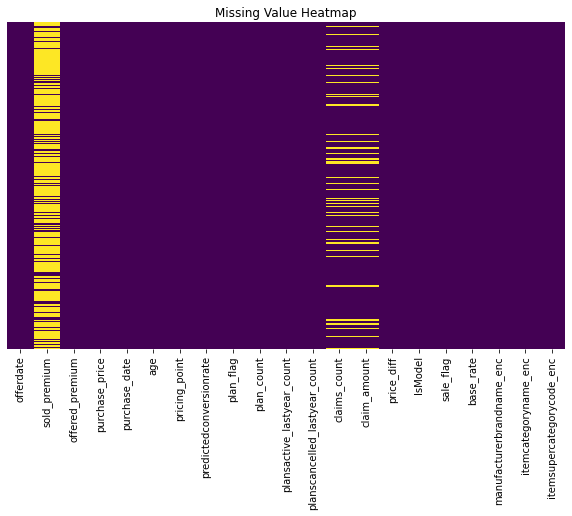

In [13]:
# create a copy of df for cleaning
df_cl = df.copy()

# 1st identify missing values and its percentage on the full data.
missing_values = df_cl.isnull().sum()
missing_percentages = 100 * df_cl.isnull().sum() / len(df)

missing_table = pd.concat([missing_values, missing_percentages], axis=1, keys=['Missing Values', 'Percentage'])
print(missing_table)

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.show()

In [14]:
# 1st lets address the sold_premium (77% missing)
## Straight away this is nothing but the sold premium price which should be there for all the sale flag 1s. But lets check that.

df_cl.query('sale_flag == 0').sold_premium.value_counts()

Series([], Name: sold_premium, dtype: int64)

In [15]:
# Inference: All good with the sold_premium missing values its just lost order which can be represented as nans or 0. 

# Impute NaNs in sold_premium as 0
df_cl['sold_premium'] = df_cl['sold_premium'].fillna(0)

# Verify the changes
print("After imputation and dropping:")
print(f"Number of NaNs in sold_premium: {df_cl['sold_premium'].isna().sum()}")
df_cl

After imputation and dropping:
Number of NaNs in sold_premium: 0


,offerdate,sold_premium,offered_premium,purchase_price,purchase_date,age,pricing_point,predictedconversionrate,plan_flag,plan_count,plansactive_lastyear_count,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,IsModel,sale_flag,base_rate,manufacturerbrandname_enc,itemcategoryname_enc,itemsupercategorycode_enc
0,2023-03-17,0.00,32.64,89.99,2023-03-16,1,@22%,0.15,0,0,0,0,0,0.00,-0.058824,Yes,0,34.68,56,35,14
1,2023-03-01,69.72,69.72,329.00,2022-12-24,67,@22%,0.81,1,5,8,2,4,347.12,-0.023529,Yes,1,71.40,123,34,3
2,2023-04-12,0.00,48.24,249.00,2023-04-05,7,@23%,0.08,0,0,0,0,0,0.00,0.210843,Yes,0,39.84,7,16,12
3,2023-03-09,0.00,91.92,746.42,2021-03-09,730,@23%,0.32,0,0,0,0,0,0.00,0.298305,Yes,0,70.80,107,36,4
4,2023-03-18,0.00,89.64,493.98,2023-03-18,0,@22%,0.25,1,1,1,0,0,0.00,0.299130,Yes,0,69.00,57,36,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8862,2023-04-10,0.00,69.72,275.00,2023-04-08,2,@23%,0.11,0,0,0,0,0,0.00,0.094162,Yes,0,63.72,7,37,4
8863,2023-03-30,69.72,69.72,262.14,2023-03-23,7,@22%,0.14,0,0,0,0,<NA>,NaN,0.218029,Yes,1,57.24,74,34,3
8864,2023-03-21,0.00,48.12,280.00,2023-03-21,0,@22%,0.12,0,0,0,0,0,0.00,-0.012315,Yes,0,48.72,62,12,4
8865,2023-03-10,0.00,69.72,550.00,2023-03-09,1,@22%,0.31,1,1,2,1,<NA>,NaN,0.249462,Yes,0,55.80,74,37,4


In [16]:
# 2nd lets address missing values in plan_counts, plansactive_lastyear_count, planscancelled_lastyear_count.

,sold_premium,offered_premium,purchase_price,age,predictedconversionrate,plan_flag,plan_count,plansactive_lastyear_count,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,sale_flag,base_rate,manufacturerbrandname_enc,itemcategoryname_enc,itemsupercategorycode_enc
sold_premium,1.000000,0.137119,0.050194,0.192426,0.157778,0.284709,0.281820,0.240405,0.148053,0.176224,0.102155,0.069628,0.951519,0.121049,0.033683,0.049487,-0.014141
offered_premium,0.137119,1.000000,0.343788,-0.000303,-0.077353,0.051889,0.041719,0.030918,0.011436,0.035498,0.037160,0.369956,0.001858,0.909448,0.073852,0.493407,-0.029868
purchase_price,0.050194,0.343788,1.000000,0.042263,-0.008916,0.009969,0.002084,0.004288,0.007428,0.019654,0.047943,0.084192,0.010700,0.328296,0.082459,-0.025719,0.009120
age,0.192426,-0.000303,0.042263,1.000000,0.197526,0.119229,0.118554,0.120538,0.096003,0.092271,0.081960,0.149156,0.202733,-0.059031,0.040798,-0.041764,0.027290
predictedconversionrate,0.157778,-0.077353,-0.008916,0.197526,1.000000,0.353039,0.366363,0.317498,0.196556,0.219624,0.134158,-0.193218,0.172427,0.002427,0.029612,0.024506,-0.005468


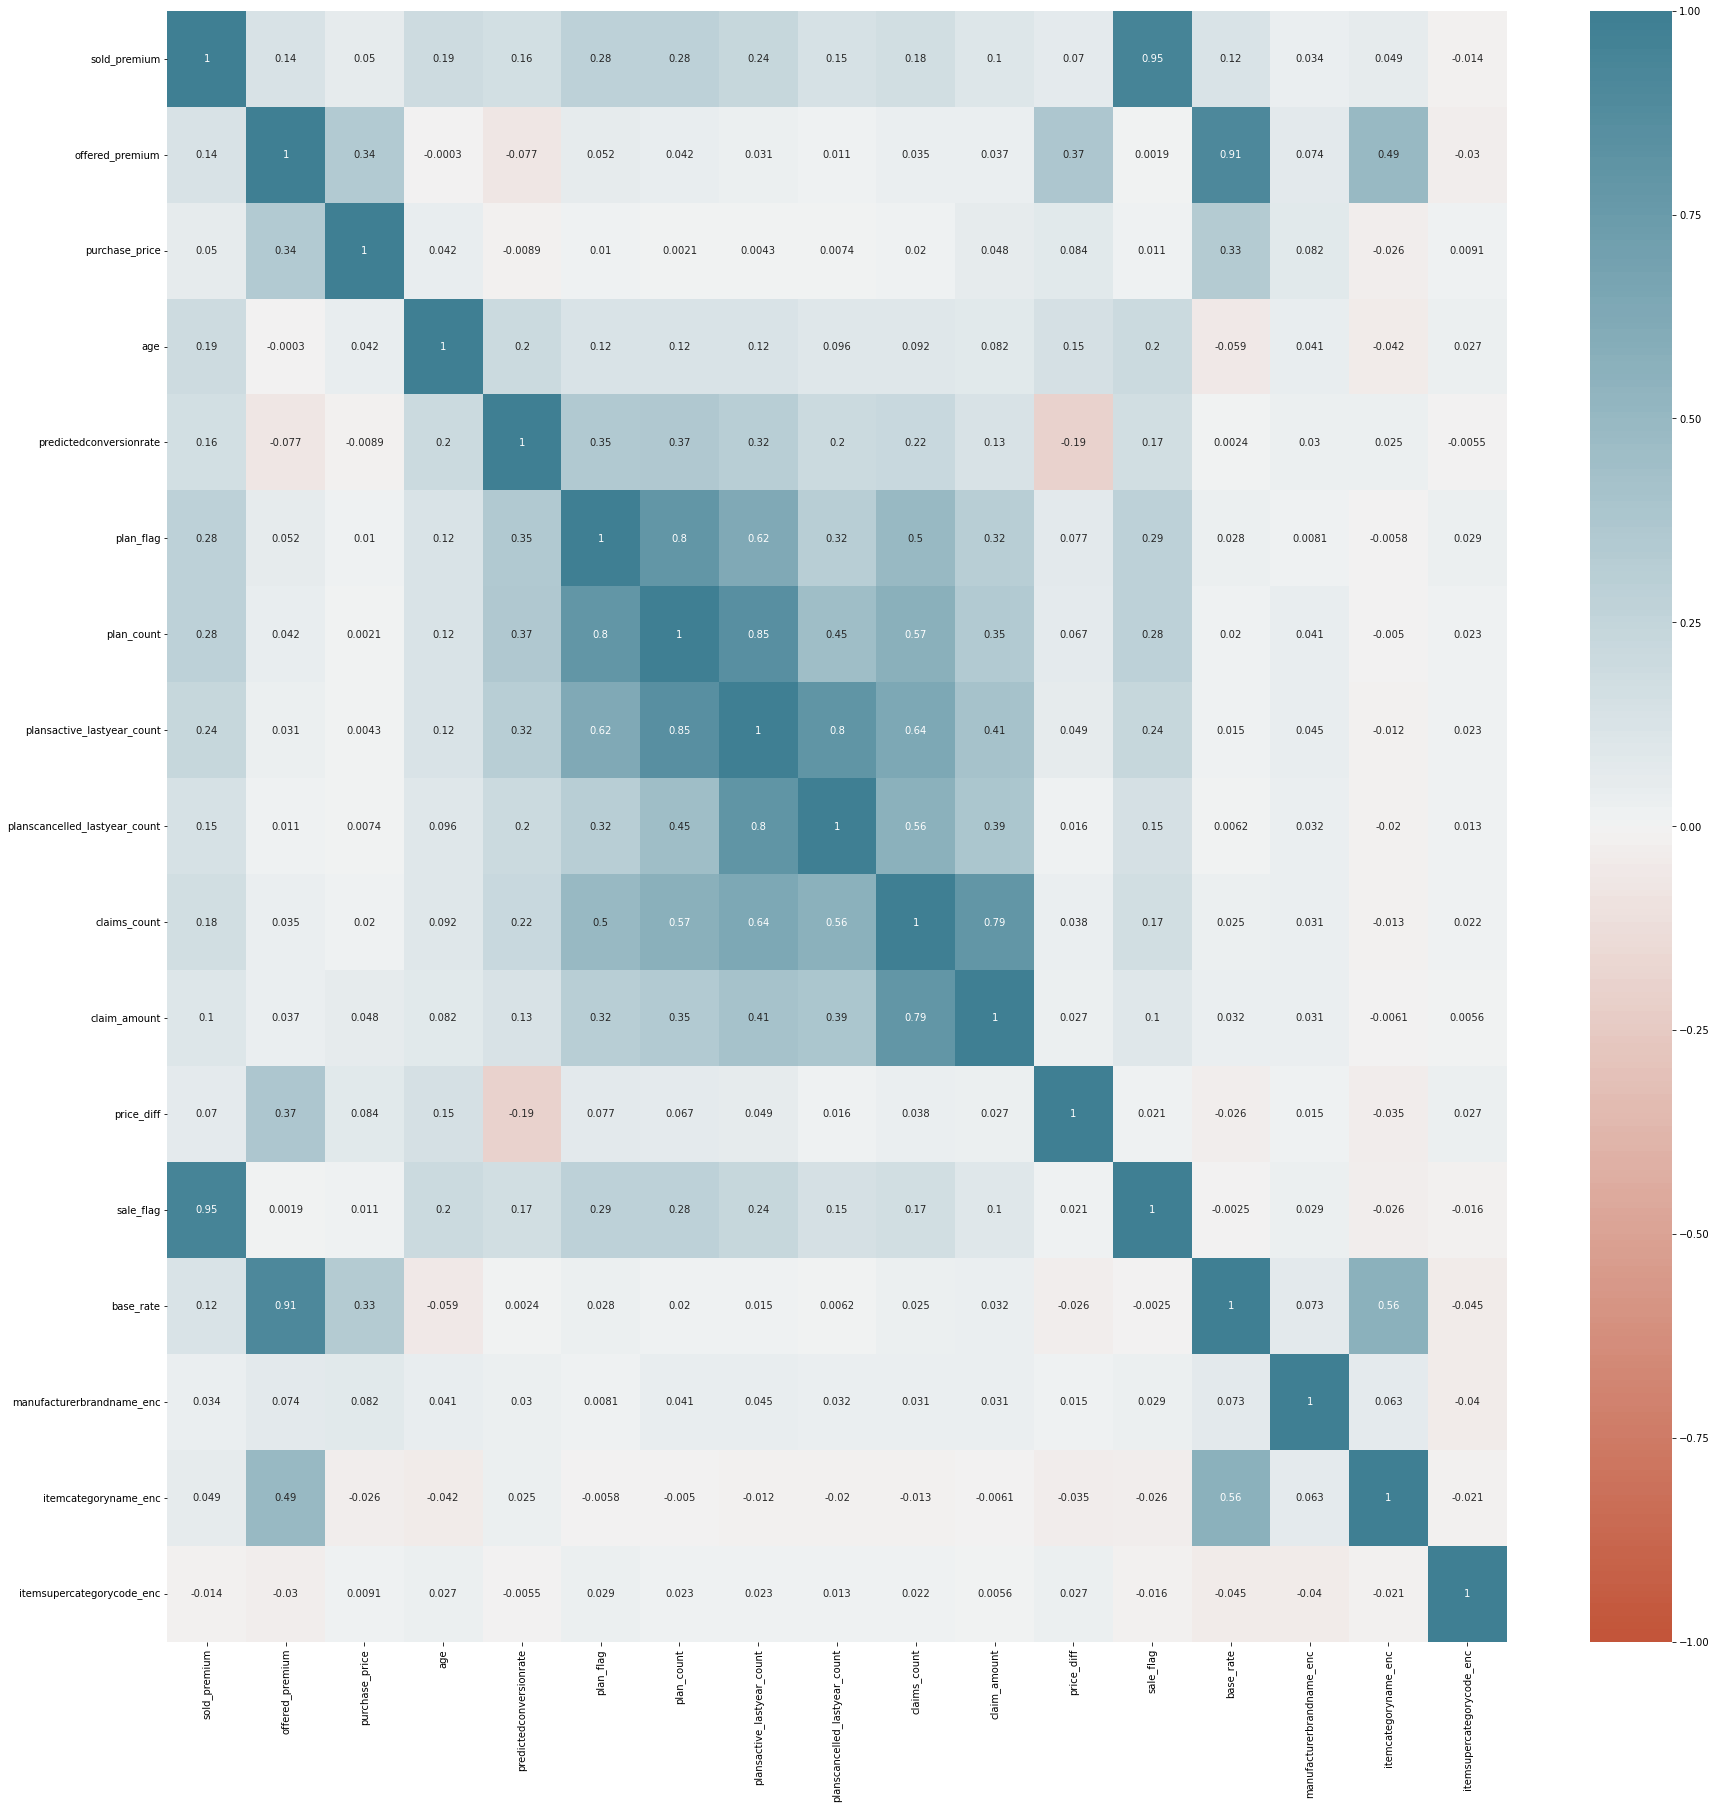

In [17]:
# coorelation matrix

corr = df_cl.corr()
plt.figure(figsize = (30,30))
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200), 
                 square=False,
                 annot=True)
corr.head()

In [18]:
## from the guidance of the above correlation and by visually seeing and playing around with filters in the excel, I found that following
## for the missing values of the count (all three variable) the plan_flag, claims_amount and claim_amount is zero. 

## plan_count:
## The plan_flag being zero says that there is no active plans and so, all the respective plan_counts should be zero. 

## plansactive_lastyear_count & planscancelled_lastyear_count:
## If we filter out all the plan_flag, claims_count and claim_amount with zero, we get 6503 rows in that plans active and cancelled last year has 6364 as zeros and just 98 as values from 1-12 (which is 1.5%). So, we are going with zero for these missing values. 

## FYI
## 75% quartile value is also zero. 
## With all these reasons imputing the 41 missing counts as zero. 
## One more information, all the missing values in count are recently purchased items from March and April of 2023.

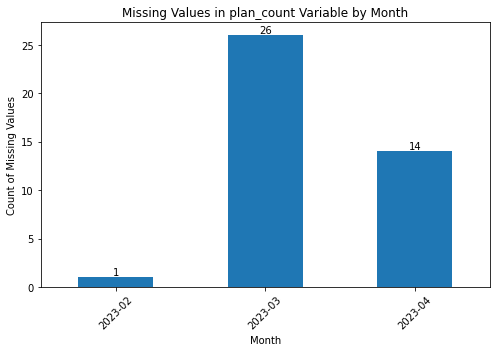

In [19]:
# Create a mask for rows with missing values in plan-related columns
missing_mask = df_cl['plan_count'].isna() | df_cl['plansactive_lastyear_count'].isna() | df_cl['planscancelled_lastyear_count'].isna()

# Get the count of missing values by month
missing_by_month = df_cl[missing_mask].groupby(df_cl['offerdate'].dt.to_period('M')).size()

# Create the bar plot
plt.figure(figsize=(7, 5))
missing_by_month.plot(kind='bar')
plt.title('Missing Values in plan_count Variable by Month')
plt.xlabel('Month')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=45)
plt.tight_layout()

# Add value labels on top of each bar
for i, v in enumerate(missing_by_month):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

In [20]:
# columns to impute
columns_to_impute = ['plan_count', 'plansactive_lastyear_count', 'planscancelled_lastyear_count']

# Create imputation flags and fill NaN with 0
for col in columns_to_impute:
    # Create flag column
    df_cl[f'{col}_imputed'] = df_cl[col].isna().astype(int)
    
    # Fill NaN with 0
    df_cl[col] = df_cl[col].fillna(0)

# Print summary of imputation
print("Imputation Summary:")
for col in columns_to_impute:
    print(f"{col}: {df_cl[f'{col}_imputed'].sum()} values imputed")

# Verify the imputation
print("\nVerification:")
for col in columns_to_impute:
    print(f"{col} - Number of NaN values after imputation: {df_cl[col].isna().sum()}")

df_cl

Imputation Summary:
plan_count: 41 values imputed
plansactive_lastyear_count: 41 values imputed
planscancelled_lastyear_count: 41 values imputed

Verification:
plan_count - Number of NaN values after imputation: 0
plansactive_lastyear_count - Number of NaN values after imputation: 0
planscancelled_lastyear_count - Number of NaN values after imputation: 0


,offerdate,sold_premium,offered_premium,purchase_price,purchase_date,age,pricing_point,predictedconversionrate,plan_flag,plan_count,plansactive_lastyear_count,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,IsModel,sale_flag,base_rate,manufacturerbrandname_enc,itemcategoryname_enc,itemsupercategorycode_enc,plan_count_imputed,plansactive_lastyear_count_imputed,planscancelled_lastyear_count_imputed
0,2023-03-17,0.00,32.64,89.99,2023-03-16,1,@22%,0.15,0,0,0,0,0,0.00,-0.058824,Yes,0,34.68,56,35,14,0,0,0
1,2023-03-01,69.72,69.72,329.00,2022-12-24,67,@22%,0.81,1,5,8,2,4,347.12,-0.023529,Yes,1,71.40,123,34,3,0,0,0
2,2023-04-12,0.00,48.24,249.00,2023-04-05,7,@23%,0.08,0,0,0,0,0,0.00,0.210843,Yes,0,39.84,7,16,12,0,0,0
3,2023-03-09,0.00,91.92,746.42,2021-03-09,730,@23%,0.32,0,0,0,0,0,0.00,0.298305,Yes,0,70.80,107,36,4,0,0,0
4,2023-03-18,0.00,89.64,493.98,2023-03-18,0,@22%,0.25,1,1,1,0,0,0.00,0.299130,Yes,0,69.00,57,36,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8862,2023-04-10,0.00,69.72,275.00,2023-04-08,2,@23%,0.11,0,0,0,0,0,0.00,0.094162,Yes,0,63.72,7,37,4,0,0,0
8863,2023-03-30,69.72,69.72,262.14,2023-03-23,7,@22%,0.14,0,0,0,0,<NA>,NaN,0.218029,Yes,1,57.24,74,34,3,0,0,0
8864,2023-03-21,0.00,48.12,280.00,2023-03-21,0,@22%,0.12,0,0,0,0,0,0.00,-0.012315,Yes,0,48.72,62,12,4,0,0,0
8865,2023-03-10,0.00,69.72,550.00,2023-03-09,1,@22%,0.31,1,1,2,1,<NA>,NaN,0.249462,Yes,0,55.80,74,37,4,0,0,0


In [21]:
# 3rd missing value - purchase_price
## Tried filtering out the itemname 24, brandname 123 unfortunately this item from this brand has been sold only once.
pp_na = df_cl[df_cl['purchase_price'].isna()]
pp_na

,offerdate,sold_premium,offered_premium,purchase_price,purchase_date,age,pricing_point,predictedconversionrate,plan_flag,plan_count,plansactive_lastyear_count,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,IsModel,sale_flag,base_rate,manufacturerbrandname_enc,itemcategoryname_enc,itemsupercategorycode_enc,plan_count_imputed,plansactive_lastyear_count_imputed,planscancelled_lastyear_count_imputed
2706,2023-04-20,40.2,40.2,NaN,2023-04-04,16,@22%,0.58,1,4,4,0,2,795.0,0.073718,Yes,1,37.44,123,24,2,0,0,0


In [22]:
## Tried filtering out the same base_rate and offered_premium which should be closley related to the same purchase price, where itemcategoryname_enc is 24 for all the four rows, so took avg. purchase price that.
pp_na1 = df_cl[(df_cl['base_rate'] == 37.44) & (df_cl['offered_premium'] == 40.2)]
pp_na1

,offerdate,sold_premium,offered_premium,purchase_price,purchase_date,age,pricing_point,predictedconversionrate,plan_flag,plan_count,plansactive_lastyear_count,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,IsModel,sale_flag,base_rate,manufacturerbrandname_enc,itemcategoryname_enc,itemsupercategorycode_enc,plan_count_imputed,plansactive_lastyear_count_imputed,planscancelled_lastyear_count_imputed
1602,2023-03-04,0.0,40.2,112.59,2023-03-04,0,@23%,0.26,1,1,1,0,0,0.00,0.073718,Yes,0,37.44,67,24,2,0,0,0
2706,2023-04-20,40.2,40.2,NaN,2023-04-04,16,@22%,0.58,1,4,4,0,2,795.00,0.073718,Yes,1,37.44,123,24,2,0,0,0
2738,2023-04-13,40.2,40.2,99.00,2022-02-04,433,@23%,0.80,1,5,28,13,5,675.82,0.073718,Yes,1,37.44,105,24,2,0,0,0
6328,2023-03-05,0.0,40.2,100.00,2022-09-05,181,@23%,0.70,1,3,3,0,0,0.00,0.073718,Yes,0,37.44,25,24,2,0,0,0


In [23]:
# imputing the purchase_price value.
average_purchase_price = pp_na1['purchase_price'].mean()
print(f"average_purchase_price is: {average_purchase_price}")

df_cl['purchase_price'] = df_cl['purchase_price'].fillna(average_purchase_price)
pp_na = df_cl[df_cl['purchase_price'].isna()]
pp_na

average_purchase_price is: 103.86333333333334


,offerdate,sold_premium,offered_premium,purchase_price,purchase_date,age,pricing_point,predictedconversionrate,plan_flag,plan_count,plansactive_lastyear_count,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,IsModel,sale_flag,base_rate,manufacturerbrandname_enc,itemcategoryname_enc,itemsupercategorycode_enc,plan_count_imputed,plansactive_lastyear_count_imputed,planscancelled_lastyear_count_imputed


In [24]:
## 4th claims_count and amount
## visually nothing can be infered by playing with filters. 

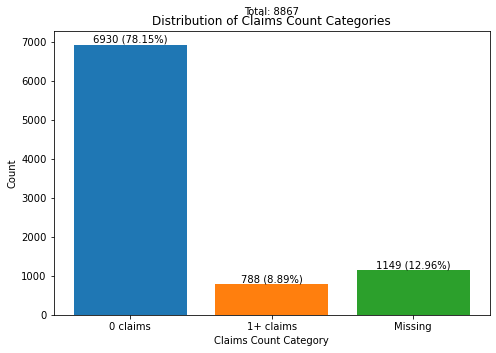

In [25]:
# Distribution of claims_count with missing values. 

def categorize_claims(count):
    if pd.isna(count):
        return 'Missing'
    elif count == 0:
        return '0 claims'
    else:
        return '1+ claims'

df_cl['claims_category'] = df_cl['claims_count'].apply(categorize_claims)

# Count the occurrences of each category
category_counts = df_cl['claims_category'].value_counts().sort_index()

# Calculate percentages
total = category_counts.sum()
category_percentages = category_counts / total * 100

# Create the bar chart
fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.bar(category_counts.index, category_counts.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

plt.title('Distribution of Claims Count Categories')
plt.xlabel('Claims Count Category')
plt.ylabel('Count')

# Add value labels on the bars
for i, (count, percentage) in enumerate(zip(category_counts, category_percentages)):
    ax.text(i, count, f'{count} ({percentage:.2f}%)', ha='center', va='bottom')

# Add total count on top of the chart
plt.text(0.5, 1.05, f'Total: {total}', ha='center', va='bottom', transform=ax.transAxes)

plt.tight_layout()
plt.show()

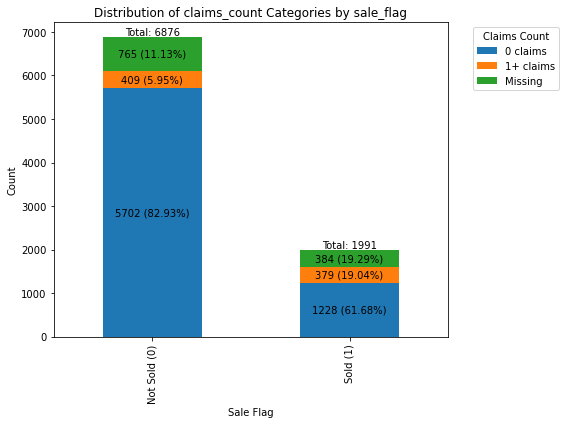

In [26]:
# Distribution on claims_count categories (0, 1+ and missing) against the sale_flag

def categorize_claims(count):
    if pd.isna(count):
        return 'Missing'
    elif count == 0:
        return '0 claims'
    else:
        return '1+ claims'

df_cl['claims_category'] = df_cl['claims_count'].apply(categorize_claims)

# Create a pivot table with counts
pivot = pd.crosstab(df_cl['sale_flag'], df_cl['claims_category'])

# Ensure all categories are present
for category in ['0 claims', '1+ claims', 'Missing']:
    if category not in pivot.columns:
        pivot[category] = 0

# Sort columns
pivot = pivot[['0 claims', '1+ claims', 'Missing']]

# Calculate percentages
pivot_perc = pivot.div(pivot.sum(axis=1), axis=0)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8, 6))
pivot.plot(kind='bar', stacked=True, ax=ax)

plt.title('Distribution of claims_count Categories by sale_flag')
plt.xlabel('Sale Flag')
plt.ylabel('Count')
plt.legend(title='Claims Count', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks([0, 1], ['Not Sold (0)', 'Sold (1)'])

# Add value labels on the bars
for c in ax.containers:
    labels = []
    for v, p in zip(c, pivot_perc[c.get_label()]):
        if v.get_height() > 0:
            labels.append(f'{int(v.get_height())} ({p:.2%})')
        else:
            labels.append('')
    ax.bar_label(c, labels=labels, label_type='center')

# Add total counts on top of each bar
totals = pivot.sum(axis=1)
for i, total in enumerate(totals):
    ax.text(i, total, f'Total: {total}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [27]:
# Inferance:
# from the chart its clear that how important is it to impute the missing values in claims_count, because the 1+ claims count is 8.89% and whereas the missing values are 12.96%. 
#  So, we cant straight away go to median/mean, and by visually seeing the data in excel and playing around with filters we found that grouping by plan_flag and taking the median should be a good approach for imputation which will not disturb the distribution of the variable, if required need to go for a sophisticated model imputation for better imputation.

In [28]:
import pandas as pd

# Columns to impute
columns_to_impute = ['claims_count', 'claim_amount']

# Create imputation flags and set initial NaNs
for col in columns_to_impute:
    df_cl[f'{col}_imputed'] = df_cl[col].isna().astype(int)  

# Function to fill missing values based on the plan_count
def impute_missing_by_plan_count(df, columns, group_col='plan_count'):
    # Only fill missing values with 0 where plan_count is 0
    for col in columns:
        df.loc[(df[col].isna()) & (df[group_col] == 0), col] = 0  # Fill NaN with 0 if plan_count is 0

    # For other plan_count values, use the median to fill missing values
    for col in columns:
        imputation_values = df.groupby(group_col)[col].transform('median')  # Calculate median by group
        
        # Fill NaN values only with the corresponding group medians
        df[col] = df[col].fillna(imputation_values)
    
    # Specifically round the 'claims_count' column if necessary
    df['claims_count'] = df['claims_count'].round()
    
    return df

# Impute missing values for claims_count and claim_amount based on plan_count
df_cl = impute_missing_by_plan_count(df_cl, columns_to_impute)

# Print summary of imputation
print("Imputation Summary:")
for col in columns_to_impute:
    print(f"{col}: {df_cl[f'{col}_imputed'].sum()} values imputed")

# Verify the imputation
print("\nVerification:")
for col in columns_to_impute:
    print(f"{col} - Number of NaN values after imputation: {df_cl[col].isna().sum()}")

df_cl

Imputation Summary:
claims_count: 1149 values imputed
claim_amount: 1149 values imputed

Verification:
claims_count - Number of NaN values after imputation: 0
claim_amount - Number of NaN values after imputation: 0


,offerdate,sold_premium,offered_premium,purchase_price,purchase_date,age,pricing_point,predictedconversionrate,plan_flag,plan_count,plansactive_lastyear_count,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,IsModel,sale_flag,base_rate,manufacturerbrandname_enc,itemcategoryname_enc,itemsupercategorycode_enc,plan_count_imputed,plansactive_lastyear_count_imputed,planscancelled_lastyear_count_imputed,claims_category,claims_count_imputed,claim_amount_imputed
0,2023-03-17,0.00,32.64,89.99,2023-03-16,1,@22%,0.15,0,0,0,0,0,0.00,-0.058824,Yes,0,34.68,56,35,14,0,0,0,0 claims,0,0
1,2023-03-01,69.72,69.72,329.00,2022-12-24,67,@22%,0.81,1,5,8,2,4,347.12,-0.023529,Yes,1,71.40,123,34,3,0,0,0,1+ claims,0,0
2,2023-04-12,0.00,48.24,249.00,2023-04-05,7,@23%,0.08,0,0,0,0,0,0.00,0.210843,Yes,0,39.84,7,16,12,0,0,0,0 claims,0,0
3,2023-03-09,0.00,91.92,746.42,2021-03-09,730,@23%,0.32,0,0,0,0,0,0.00,0.298305,Yes,0,70.80,107,36,4,0,0,0,0 claims,0,0
4,2023-03-18,0.00,89.64,493.98,2023-03-18,0,@22%,0.25,1,1,1,0,0,0.00,0.299130,Yes,0,69.00,57,36,4,0,0,0,0 claims,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8862,2023-04-10,0.00,69.72,275.00,2023-04-08,2,@23%,0.11,0,0,0,0,0,0.00,0.094162,Yes,0,63.72,7,37,4,0,0,0,0 claims,0,0
8863,2023-03-30,69.72,69.72,262.14,2023-03-23,7,@22%,0.14,0,0,0,0,0,0.00,0.218029,Yes,1,57.24,74,34,3,0,0,0,Missing,1,1
8864,2023-03-21,0.00,48.12,280.00,2023-03-21,0,@22%,0.12,0,0,0,0,0,0.00,-0.012315,Yes,0,48.72,62,12,4,0,0,0,0 claims,0,0
8865,2023-03-10,0.00,69.72,550.00,2023-03-09,1,@22%,0.31,1,1,2,1,0,0.00,0.249462,Yes,0,55.80,74,37,4,0,0,0,Missing,1,1


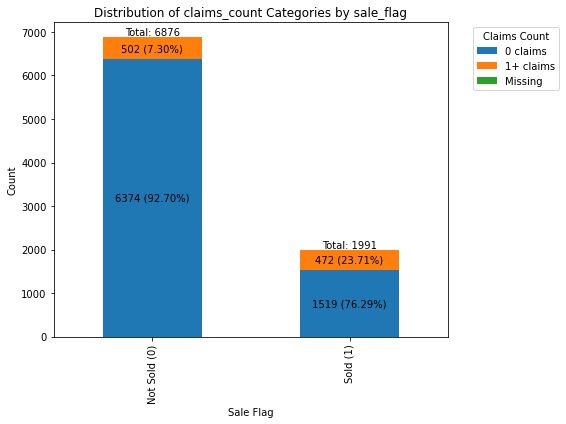

In [29]:
# Distribution on claims_count categories (0, 1+ with imputed missing values) against the sale_flag

def categorize_claims(count):
    if pd.isna(count):
        return 'Missing'
    elif count == 0:
        return '0 claims'
    else:
        return '1+ claims'

df_cl['claims_category'] = df_cl['claims_count'].apply(categorize_claims)

# Create a pivot table with counts
pivot = pd.crosstab(df_cl['sale_flag'], df_cl['claims_category'])

# Ensure all categories are present
for category in ['0 claims', '1+ claims', 'Missing']:
    if category not in pivot.columns:
        pivot[category] = 0

# Sort columns
pivot = pivot[['0 claims', '1+ claims', 'Missing']]

# Calculate percentages
pivot_perc = pivot.div(pivot.sum(axis=1), axis=0)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8, 6))
pivot.plot(kind='bar', stacked=True, ax=ax)

plt.title('Distribution of claims_count Categories by sale_flag')
plt.xlabel('Sale Flag')
plt.ylabel('Count')
plt.legend(title='Claims Count', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks([0, 1], ['Not Sold (0)', 'Sold (1)'])

# Add value labels on the bars
for c in ax.containers:
    labels = []
    for v, p in zip(c, pivot_perc[c.get_label()]):
        if v.get_height() > 0:
            labels.append(f'{int(v.get_height())} ({p:.2%})')
        else:
            labels.append('')
    ax.bar_label(c, labels=labels, label_type='center')

# Add total counts on top of each bar
totals = pivot.sum(axis=1)
for i, total in enumerate(totals):
    ax.text(i, total, f'Total: {total}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [30]:
check = df_cl[(df_cl['claims_count_imputed'] == 1) & (df_cl['plan_count'] == 5)]
check.head(10)

,offerdate,sold_premium,offered_premium,purchase_price,purchase_date,age,pricing_point,predictedconversionrate,plan_flag,plan_count,plansactive_lastyear_count,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,IsModel,sale_flag,base_rate,manufacturerbrandname_enc,itemcategoryname_enc,itemsupercategorycode_enc,plan_count_imputed,plansactive_lastyear_count_imputed,planscancelled_lastyear_count_imputed,claims_category,claims_count_imputed,claim_amount_imputed
471,2023-03-23,0.00,45.00,159.99,2023-03-21,2,@22%,0.50,1,5,5,0,2,195.02,0.297578,Yes,0,34.68,86,32,13,0,0,0,1+ claims,1,1
1262,2023-03-20,39.48,39.48,500.00,2023-03-06,14,ASIS FEE,1.00,1,5,9,1,2,195.02,0.000000,No,1,39.48,30,13,7,0,0,0,1+ claims,1,1
1290,2023-04-14,105.24,105.24,599.00,2022-12-22,113,@23%,0.50,1,5,7,1,2,195.02,0.299259,Yes,1,81.00,7,36,4,0,0,0,1+ claims,1,1
1359,2023-03-21,69.72,69.72,840.00,2023-03-21,0,@23%,0.69,1,5,6,1,2,195.02,0.265795,Yes,1,55.08,74,12,4,0,0,0,1+ claims,1,1
2006,2023-03-08,0.00,69.72,250.00,2023-03-08,0,@23%,0.59,1,5,8,1,2,195.02,0.218029,Yes,0,57.24,123,34,3,0,0,0,1+ claims,1,1
2382,2023-03-28,0.00,69.36,335.98,2023-03-27,1,@22%,0.42,1,5,7,0,2,195.02,0.211740,Yes,0,57.24,74,34,3,0,0,0,1+ claims,1,1
2580,2023-03-16,0.00,47.28,300.00,2023-03-16,0,@23%,0.47,1,5,8,0,2,195.02,-0.064133,Yes,0,50.52,17,16,12,0,0,0,1+ claims,1,1
2761,2023-04-03,69.36,69.36,259.00,2023-03-20,14,@23%,0.69,1,5,7,2,2,195.02,0.211740,Yes,1,57.24,119,34,3,0,0,0,1+ claims,1,1
2943,2023-04-07,0.00,69.72,348.00,2023-04-04,3,@23%,0.52,1,5,5,0,2,195.02,0.048736,Yes,0,66.48,56,37,4,0,0,0,1+ claims,1,1
3298,2023-04-24,0.00,43.32,360.00,2023-04-21,3,@23%,0.58,1,5,5,0,2,195.02,0.087349,Yes,0,39.84,7,14,12,0,0,0,1+ claims,1,1


In [31]:
#missing value check
missing_values = df_cl.isnull().sum()
missing_values

offerdate                                0
sold_premium                             0
offered_premium                          0
purchase_price                           0
purchase_date                            0
age                                      0
pricing_point                            0
predictedconversionrate                  0
plan_flag                                0
plan_count                               0
plansactive_lastyear_count               0
planscancelled_lastyear_count            0
claims_count                             0
claim_amount                             0
price_diff                               0
IsModel                                  0
sale_flag                                0
base_rate                                0
manufacturerbrandname_enc                0
itemcategoryname_enc                     0
itemsupercategorycode_enc                0
plan_count_imputed                       0
plansactive_lastyear_count_imputed       0
planscancel

# 1.3 Handling duplicates

In [32]:
# Check for duplicates
duplicate_rows = df_cl[df_cl.duplicated(keep=False)]
duplicate_rows

,offerdate,sold_premium,offered_premium,purchase_price,purchase_date,age,pricing_point,predictedconversionrate,plan_flag,plan_count,plansactive_lastyear_count,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,IsModel,sale_flag,base_rate,manufacturerbrandname_enc,itemcategoryname_enc,itemsupercategorycode_enc,plan_count_imputed,plansactive_lastyear_count_imputed,planscancelled_lastyear_count_imputed,claims_category,claims_count_imputed,claim_amount_imputed
1828,2023-04-03,0.0,26.52,300.0,2023-03-31,3,ASIS FEE,1.0,0,0,0,0,0,0.0,0.0,No,0,26.52,129,19,2,0,0,0,0 claims,0,0
3112,2023-04-13,0.0,64.68,600.0,2022-03-06,403,ASIS FEE,1.0,0,0,0,0,0,0.0,0.0,No,0,64.68,7,37,4,0,0,0,0 claims,0,0
3829,2023-04-03,0.0,26.52,300.0,2023-03-31,3,ASIS FEE,1.0,0,0,0,0,0,0.0,0.0,No,0,26.52,129,19,2,0,0,0,0 claims,0,0
4739,2023-04-13,0.0,64.68,600.0,2022-03-06,403,ASIS FEE,1.0,0,0,0,0,0,0.0,0.0,No,0,64.68,7,37,4,0,0,0,0 claims,0,0


In [33]:
# Deleting the duplicate rows 
df_cl = df_cl.drop_duplicates(keep='first')
df_cl

,offerdate,sold_premium,offered_premium,purchase_price,purchase_date,age,pricing_point,predictedconversionrate,plan_flag,plan_count,plansactive_lastyear_count,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,IsModel,sale_flag,base_rate,manufacturerbrandname_enc,itemcategoryname_enc,itemsupercategorycode_enc,plan_count_imputed,plansactive_lastyear_count_imputed,planscancelled_lastyear_count_imputed,claims_category,claims_count_imputed,claim_amount_imputed
0,2023-03-17,0.00,32.64,89.99,2023-03-16,1,@22%,0.15,0,0,0,0,0,0.00,-0.058824,Yes,0,34.68,56,35,14,0,0,0,0 claims,0,0
1,2023-03-01,69.72,69.72,329.00,2022-12-24,67,@22%,0.81,1,5,8,2,4,347.12,-0.023529,Yes,1,71.40,123,34,3,0,0,0,1+ claims,0,0
2,2023-04-12,0.00,48.24,249.00,2023-04-05,7,@23%,0.08,0,0,0,0,0,0.00,0.210843,Yes,0,39.84,7,16,12,0,0,0,0 claims,0,0
3,2023-03-09,0.00,91.92,746.42,2021-03-09,730,@23%,0.32,0,0,0,0,0,0.00,0.298305,Yes,0,70.80,107,36,4,0,0,0,0 claims,0,0
4,2023-03-18,0.00,89.64,493.98,2023-03-18,0,@22%,0.25,1,1,1,0,0,0.00,0.299130,Yes,0,69.00,57,36,4,0,0,0,0 claims,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8862,2023-04-10,0.00,69.72,275.00,2023-04-08,2,@23%,0.11,0,0,0,0,0,0.00,0.094162,Yes,0,63.72,7,37,4,0,0,0,0 claims,0,0
8863,2023-03-30,69.72,69.72,262.14,2023-03-23,7,@22%,0.14,0,0,0,0,0,0.00,0.218029,Yes,1,57.24,74,34,3,0,0,0,0 claims,1,1
8864,2023-03-21,0.00,48.12,280.00,2023-03-21,0,@22%,0.12,0,0,0,0,0,0.00,-0.012315,Yes,0,48.72,62,12,4,0,0,0,0 claims,0,0
8865,2023-03-10,0.00,69.72,550.00,2023-03-09,1,@22%,0.31,1,1,2,1,0,0.00,0.249462,Yes,0,55.80,74,37,4,0,0,0,0 claims,1,1


In [34]:
# changing dtype from Int32 to int
## int can't handle Nans so we used Int32 before dealing with missing values, now changing in to int for further analysis.
df_cl['plan_count'] = df_cl['plan_count'].astype('int')
df_cl['plansactive_lastyear_count'] = df_cl['plansactive_lastyear_count'].astype('int')
df_cl['planscancelled_lastyear_count'] = df_cl['planscancelled_lastyear_count'].astype('int')
df_cl['claims_count'] = df_cl['claims_count'].astype('int')

df_cl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8865 entries, 0 to 8866
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   offerdate                              8865 non-null   datetime64[ns]
 1   sold_premium                           8865 non-null   float64       
 2   offered_premium                        8865 non-null   float64       
 3   purchase_price                         8865 non-null   float64       
 4   purchase_date                          8865 non-null   datetime64[ns]
 5   age                                    8865 non-null   int32         
 6   pricing_point                          8865 non-null   object        
 7   predictedconversionrate                8865 non-null   float64       
 8   plan_flag                              8865 non-null   int64         
 9   plan_count                             8865 non-null   int32   

C:\Users\deenu\AppData\Local\Temp\ipykernel_5712\4191912067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cl['plan_count'] = df_cl['plan_count'].astype('int')
C:\Users\deenu\AppData\Local\Temp\ipykernel_5712\4191912067.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cl['plansactive_lastyear_count'] = df_cl['plansactive_lastyear_count'].astype('int')
C:\Users\deenu\AppData\Local\Temp\ipykernel_5712\4191912067.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [35]:
# Save df_cl as an Excel file
#df_cl.to_excel('df_cl_output.xlsx', index=False)


# 2. Assessment Questions

# 2.a EDA
a) Explore the dataset and conduct any EDA that you feel will help you understand the data. 

In [36]:
df_cl.describe()

,sold_premium,offered_premium,purchase_price,age,predictedconversionrate,plan_flag,plan_count,plansactive_lastyear_count,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,sale_flag,base_rate,manufacturerbrandname_enc,itemcategoryname_enc,itemsupercategorycode_enc,plan_count_imputed,plansactive_lastyear_count_imputed,planscancelled_lastyear_count_imputed,claims_count_imputed,claim_amount_imputed
count,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000
mean,11.922518,53.030944,406.670371,57.379921,0.315839,0.197180,0.407445,0.680880,0.231923,0.207332,27.574701,0.080782,0.224591,49.091763,53.761534,22.600000,4.677496,0.004625,0.004625,0.004625,0.129611,0.129611
std,23.283352,16.272816,214.195383,133.001044,0.298107,0.397892,1.031887,1.962424,0.980010,0.850974,175.539785,0.129807,0.417336,13.564243,38.929875,10.902969,3.894696,0.067853,0.067853,0.067853,0.335894,0.335894
min,0.000000,12.720000,19.990000,-37.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.298643,0.000000,18.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,45.000000,295.000000,1.000000,0.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.480000,16.000000,12.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,48.120000,330.000000,7.000000,0.190000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069149,0.000000,45.960000,57.000000,19.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,63.600000,471.380000,33.000000,0.370000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.169096,0.000000,59.640000,74.000000,36.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,150.000000,150.000000,1200.000000,1096.000000,1.000000,1.000000,5.000000,32.000000,25.000000,30.000000,10523.030000,0.299886,1.000000,150.000000,130.000000,37.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000


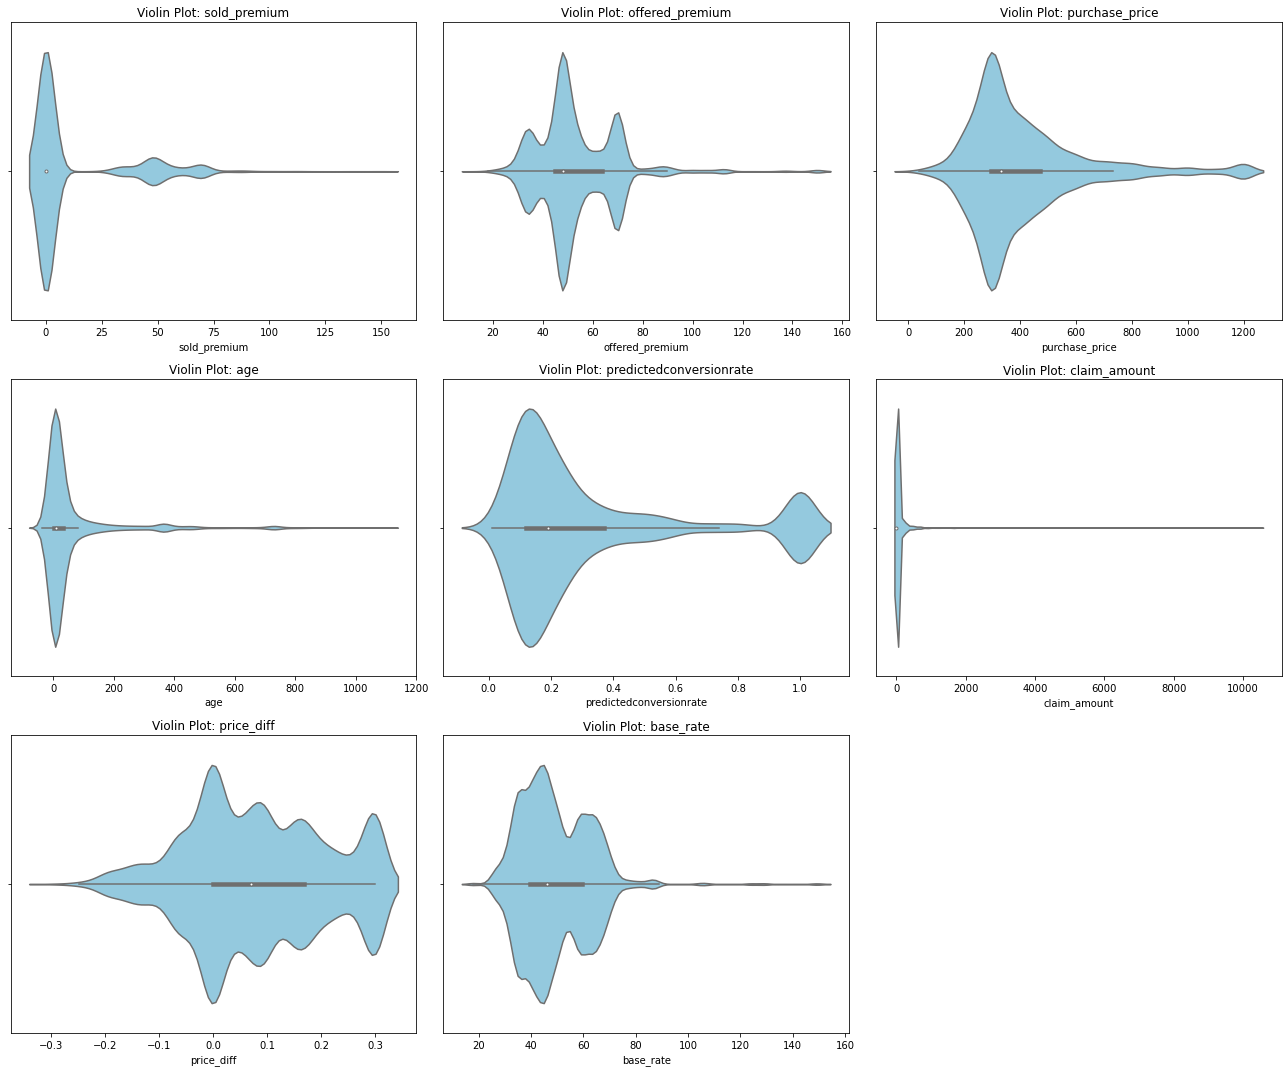

In [37]:
# Distribution of numeric variables

#Select only continuous numeric columns
cont_numeric_columns = ['sold_premium', 'offered_premium', 'purchase_price', 'age', 'predictedconversionrate', 
                        'claim_amount','price_diff','base_rate']

# Set up the plot grid size 
n_cols = 3  # Number of plots per row
n_rows = (len(cont_numeric_columns) // n_cols) + 1  # Number of rows required

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()  # Flatten axes for easy indexing in loop

# Loop through each numeric column and create a horizontal violin plot with count scaling
for i, col in enumerate(cont_numeric_columns):
    sns.violinplot(data=df_cl, x=col, ax=axes[i], color='skyblue', orient='h', scale='count')  # Scale based on count
    axes[i].set_title(f'Violin Plot: {col}')
    axes[i].set_ylabel('')  # Remove the y-label for clarity

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

,sold_premium,offered_premium,purchase_price,age,predictedconversionrate,plan_flag,plan_count,plansactive_lastyear_count,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,sale_flag,base_rate,manufacturerbrandname_enc,itemcategoryname_enc,itemsupercategorycode_enc
sold_premium,1.000000,0.137119,0.050194,0.192426,0.157778,0.284709,0.281820,0.240405,0.148053,0.176224,0.102155,0.069628,0.951519,0.121049,0.033683,0.049487,-0.014141
offered_premium,0.137119,1.000000,0.343788,-0.000303,-0.077353,0.051889,0.041719,0.030918,0.011436,0.035498,0.037160,0.369956,0.001858,0.909448,0.073852,0.493407,-0.029868
purchase_price,0.050194,0.343788,1.000000,0.042263,-0.008916,0.009969,0.002084,0.004288,0.007428,0.019654,0.047943,0.084192,0.010700,0.328296,0.082459,-0.025719,0.009120
age,0.192426,-0.000303,0.042263,1.000000,0.197526,0.119229,0.118554,0.120538,0.096003,0.092271,0.081960,0.149156,0.202733,-0.059031,0.040798,-0.041764,0.027290
predictedconversionrate,0.157778,-0.077353,-0.008916,0.197526,1.000000,0.353039,0.366363,0.317498,0.196556,0.219624,0.134158,-0.193218,0.172427,0.002427,0.029612,0.024506,-0.005468


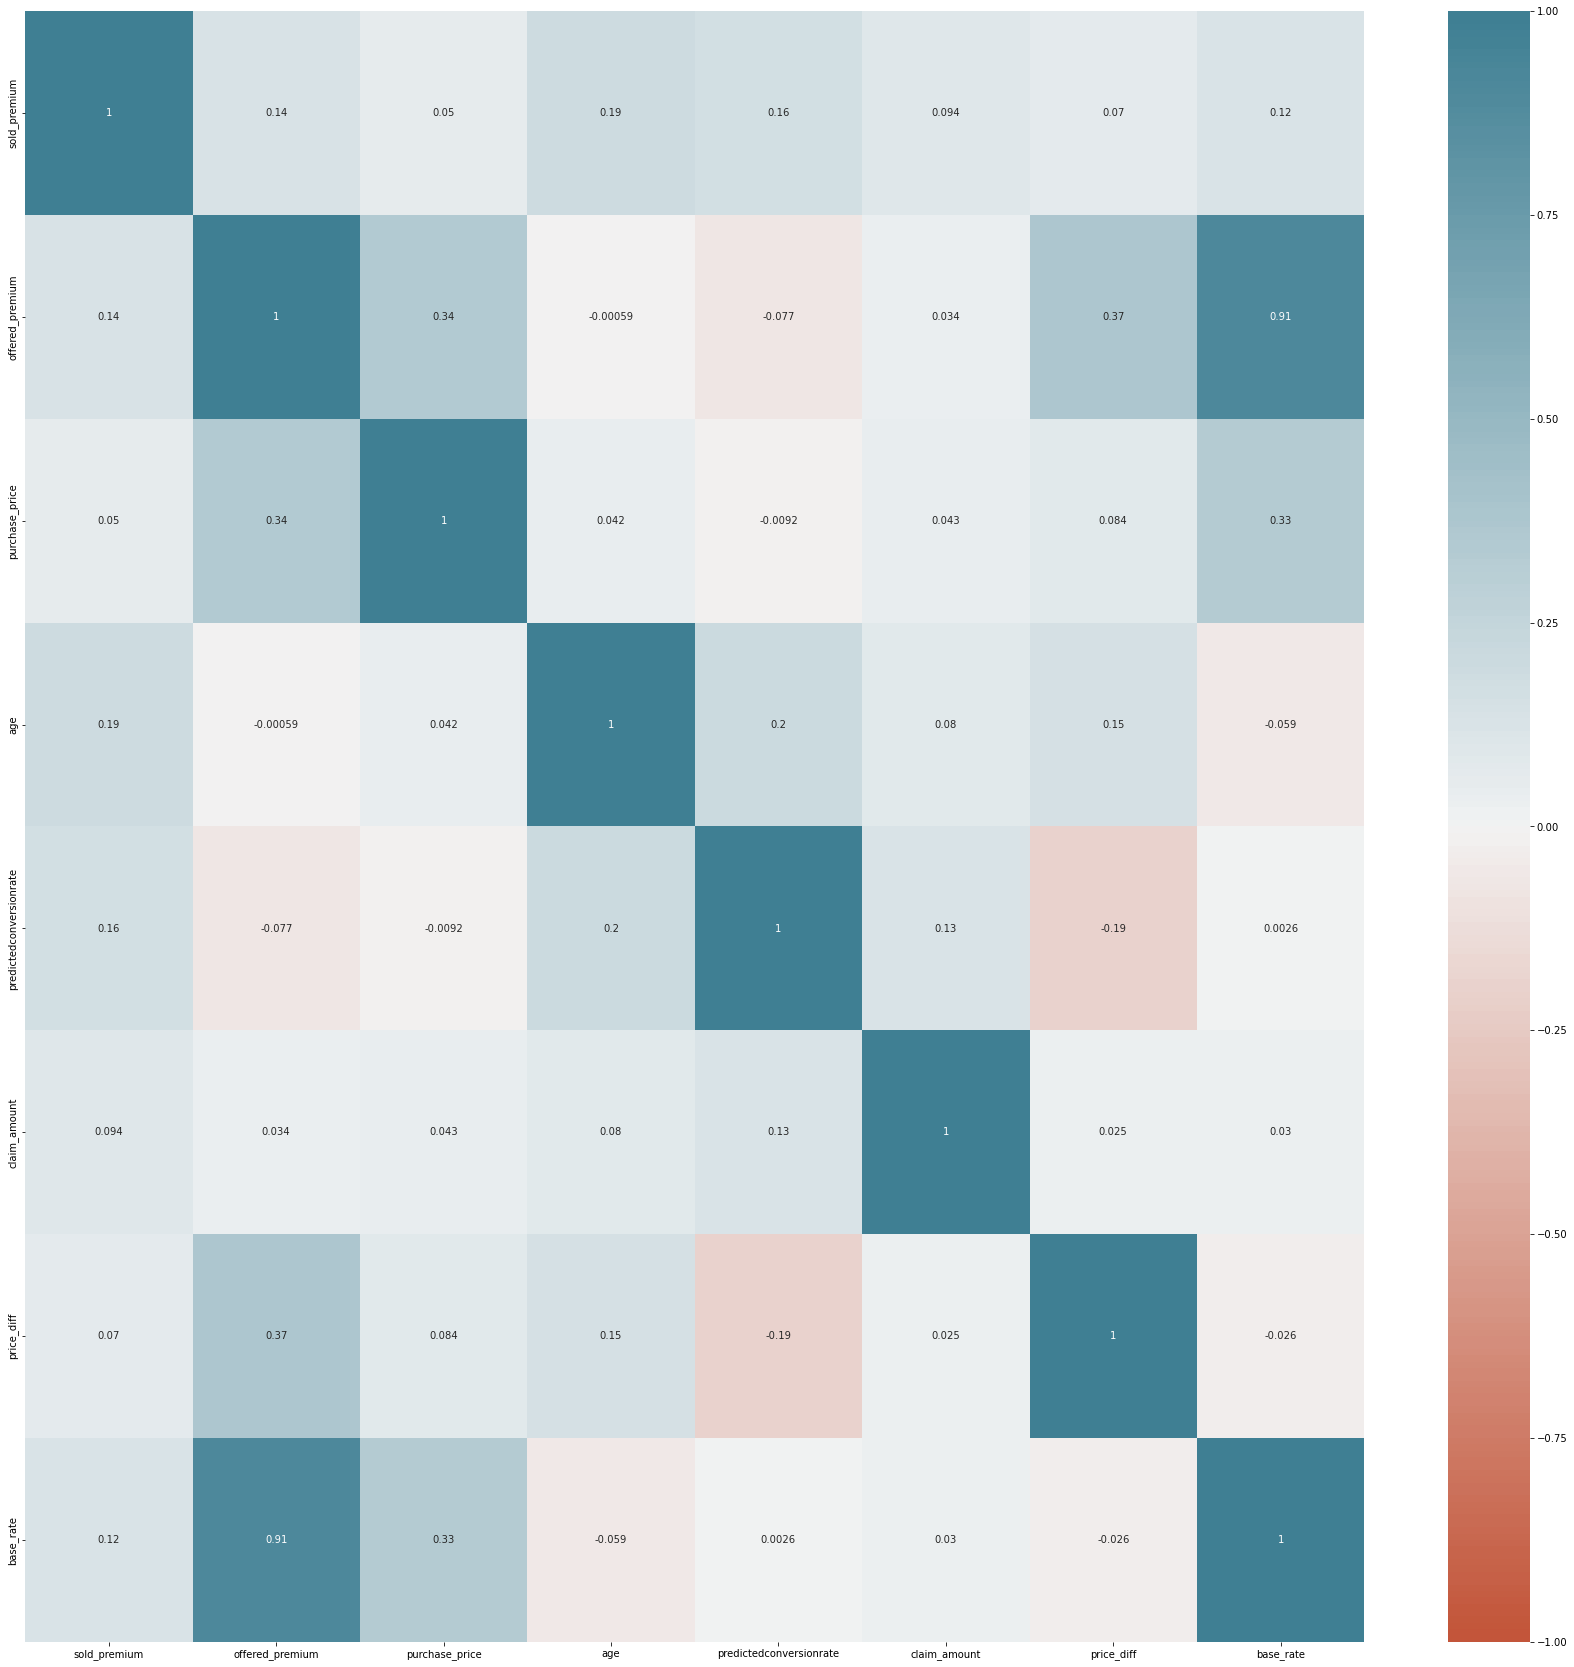

In [38]:
# Correlation Analysis for continuous variables

cont_num_df = df_cl[['sold_premium', 'offered_premium', 'purchase_price', 'age', 'predictedconversionrate', 
                        'claim_amount','price_diff','base_rate']]
corr1 = cont_num_df.corr()
plt.figure(figsize = (30,30))
ax = sns.heatmap(corr1, vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200), 
                 square=False,
                 annot=True)
corr.head()

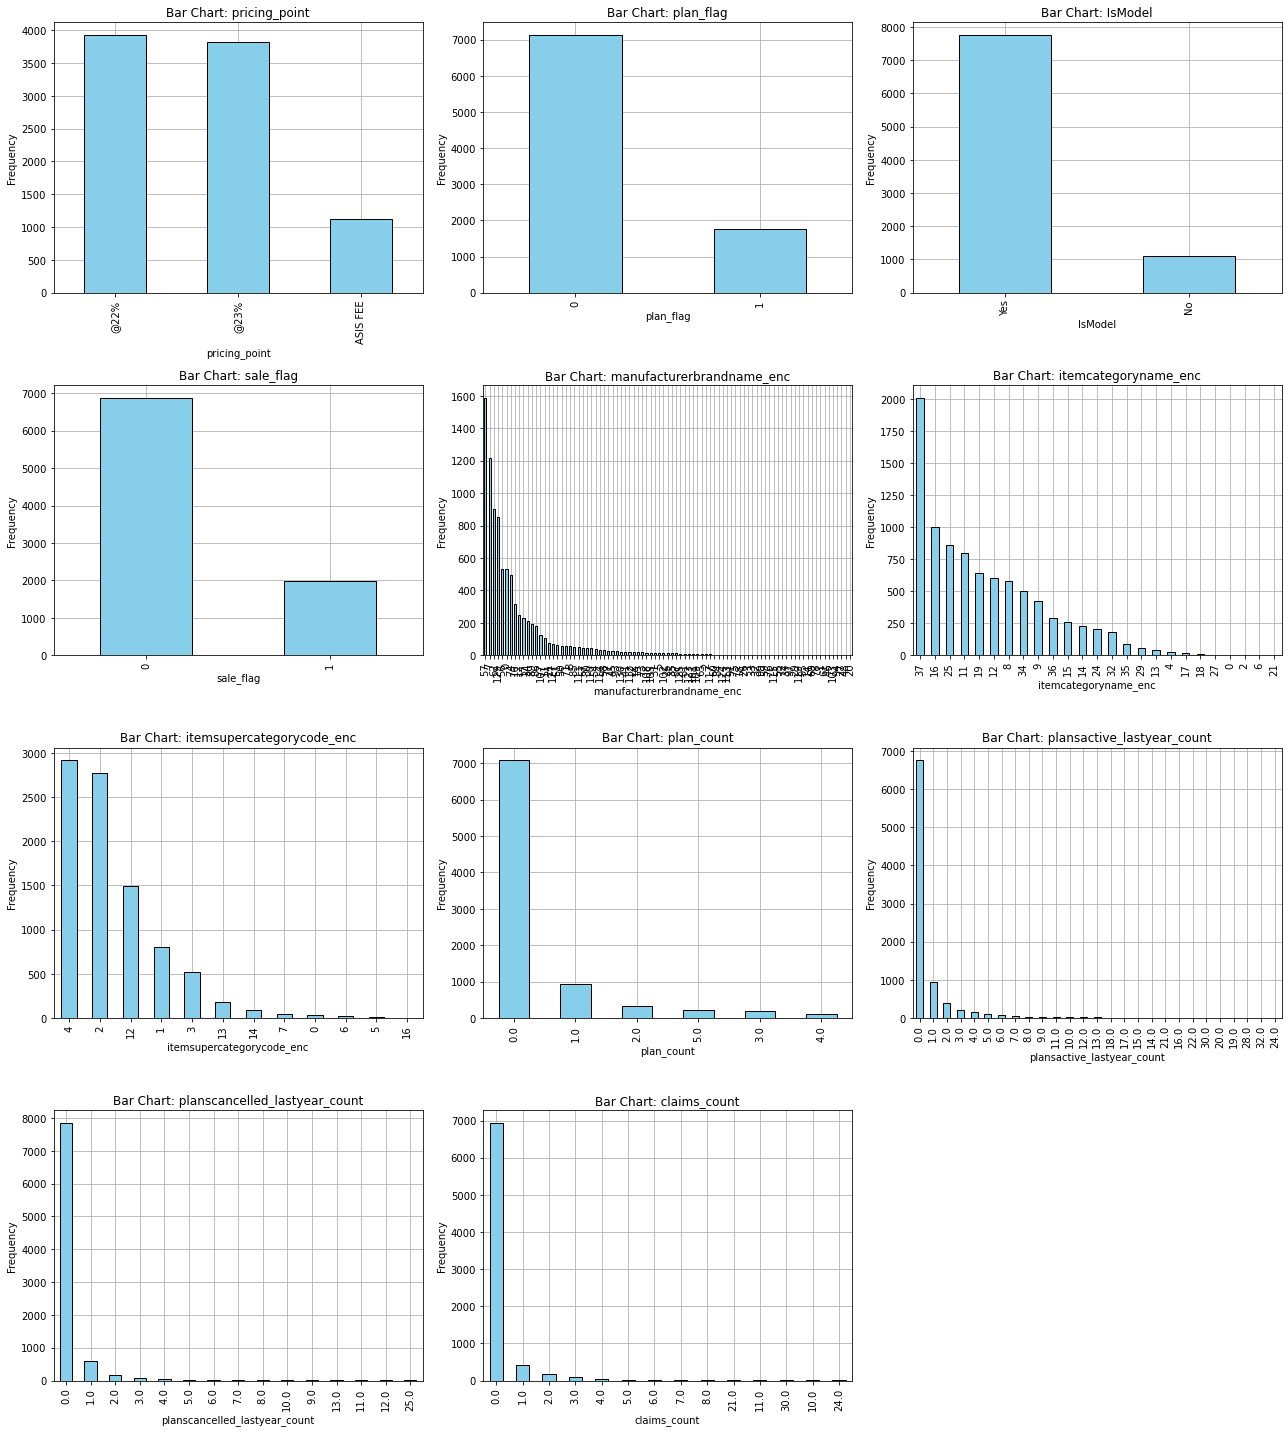

In [39]:
# Distribution of categorical and count variables

# Setting up the bar chart for categorical and count variables with a grid layout as requested
categorical_columns = ['pricing_point', 'plan_flag', 'IsModel', 'sale_flag', 'manufacturerbrandname_enc', 'itemcategoryname_enc', 'itemsupercategorycode_enc']
count_vars = ['plan_count', 'plansactive_lastyear_count', 'planscancelled_lastyear_count', 'claims_count']

# Combine categorical and count variables
cat_count_vars = categorical_columns + count_vars

# setup plot grid size
n_cols = 3  # Number of plots per row
n_rows = (len(cat_count_vars) // n_cols) + 1  # Number of rows required

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

# Loop through each column and create bar charts with gridlines behind the bars
for i, col in enumerate(cat_count_vars):
    axes[i].set_axisbelow(True)  
    data[col].value_counts().plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black', zorder=3)
    axes[i].set_title(f'Bar Chart: {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, zorder=0)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

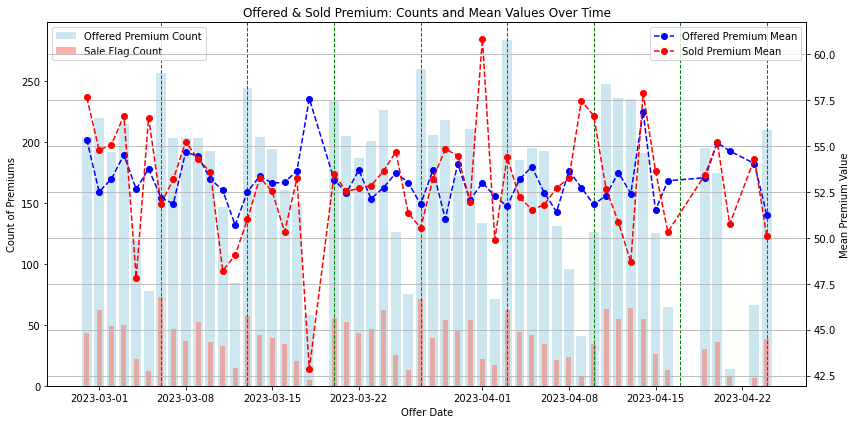

In [40]:
# Temporal Analysis

# Group by offer_data (date) to get daily counts and means for offered and sold premiums
daily_data = df_cl.groupby(df_cl['offerdate'].dt.date).agg({
    'offered_premium': ['count', 'mean'],
    'sale_flag': ['sum'],
    'sold_premium': ['sum']
}).reset_index()

# Rename the columns
daily_data.columns = ['offerdate', 'offered_premium_count', 'offered_premium_mean', 'sale_flag_count', 'sold_premium_sum']
daily_data['sold_premium_mean'] = daily_data['sold_premium_sum'] / daily_data['sale_flag_count']

# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the histogram part - count of offered and sold premiums
ax1.bar(daily_data['offerdate'], daily_data['offered_premium_count'], color='lightblue', alpha=0.6, label='Offered Premium Count')
ax1.bar(daily_data['offerdate'], daily_data['sale_flag_count'], color='salmon', alpha=0.6, label='Sale Flag Count', width=0.4)

# Set labels for the first y-axis (left)
ax1.set_ylabel('Count of Premiums')
ax1.set_xlabel('Offer Date')
ax1.set_title('Offered & Sold Premium: Counts and Mean Values Over Time')

# Highlight weekly boundaries using vertical lines
weeks = pd.date_range(start=daily_data['offerdate'].min(), end=daily_data['offerdate'].max(), freq='W-MON')
for week in weeks:
    ax1.axvline(x=week, color='green', linestyle='--', linewidth=1)  # Vertical dashed line for each week start (Monday)

# Create a second y-axis (right) for the line plots of mean values
ax2 = ax1.twinx()

# Plot the mean values of offered and sold premiums
ax2.plot(daily_data['offerdate'], daily_data['offered_premium_mean'], color='blue', label='Offered Premium Mean', linestyle='--', marker='o')
ax2.plot(daily_data['offerdate'], daily_data['sold_premium_mean'], color='red', label='Sold Premium Mean', linestyle='--', marker='o')

# Set labels for the second y-axis (right)
ax2.set_ylabel('Mean Premium Value')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xticks(rotation=45)
plt.grid()

plt.tight_layout()
plt.show()

In [41]:
# we got to know that the entire row is missing for 19 of March and 17,18,22 of April.

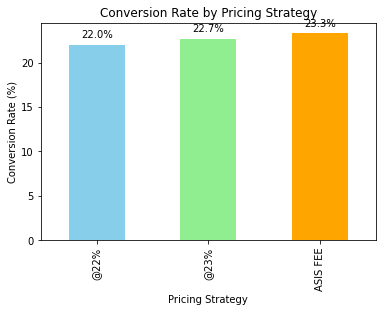

In [42]:
# Coversion rate - group by pricing_point:

# Group by pricing_point and sale_flag, then calculate the count and conversion rate
pricing_conversion = df_cl.groupby(['pricing_point', 'sale_flag']).size().unstack(fill_value=0)
pricing_conversion['conversion_rate'] = pricing_conversion[1] / (pricing_conversion[0] + pricing_conversion[1]) * 100

# Plot the conversion rate
ax = pricing_conversion['conversion_rate'].plot(kind='bar', color=['skyblue', 'lightgreen', 'orange'])

# Add numbers on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Conversion Rate by Pricing Strategy')
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Pricing Strategy')
plt.show()

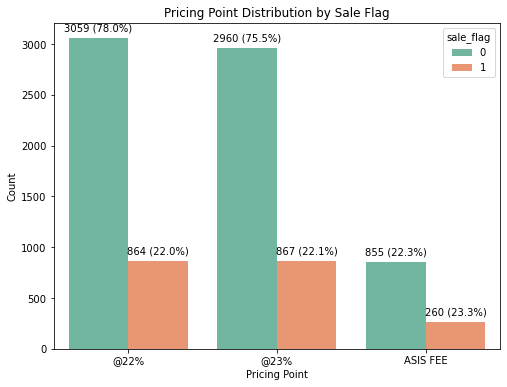

In [43]:
# Pricing Strategy (pricing_point) vs Sale Flag (sale_flag):

# Create the grouped bar plot with pricing_point on the x-axis and sale_flag as the hue
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='pricing_point', hue='sale_flag', data=df_cl, palette='Set2')

# Calculate the total number of each pricing_point to compute percentages for each bar
total_by_pricing_point = df_cl.groupby('pricing_point')['sale_flag'].count()

# Annotate the bars with count values and percentages
for p in ax.patches:
    height = p.get_height()  
    pricing_point = p.get_x() + p.get_width() / 2.0  
    # Extract the category from the current bar (pricing_point) and use it to calculate total
    current_pricing_point = p.get_x()  
    total = total_by_pricing_point.iloc[int(current_pricing_point)]  
    percentage = (height / total) * 100 
    ax.annotate(f'{int(height)} ({percentage:.1f}%)', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points')

# Add title and labels
plt.title('Pricing Point Distribution by Sale Flag')
plt.xlabel('Pricing Point')
plt.ylabel('Count')

# Show the plot
plt.show()

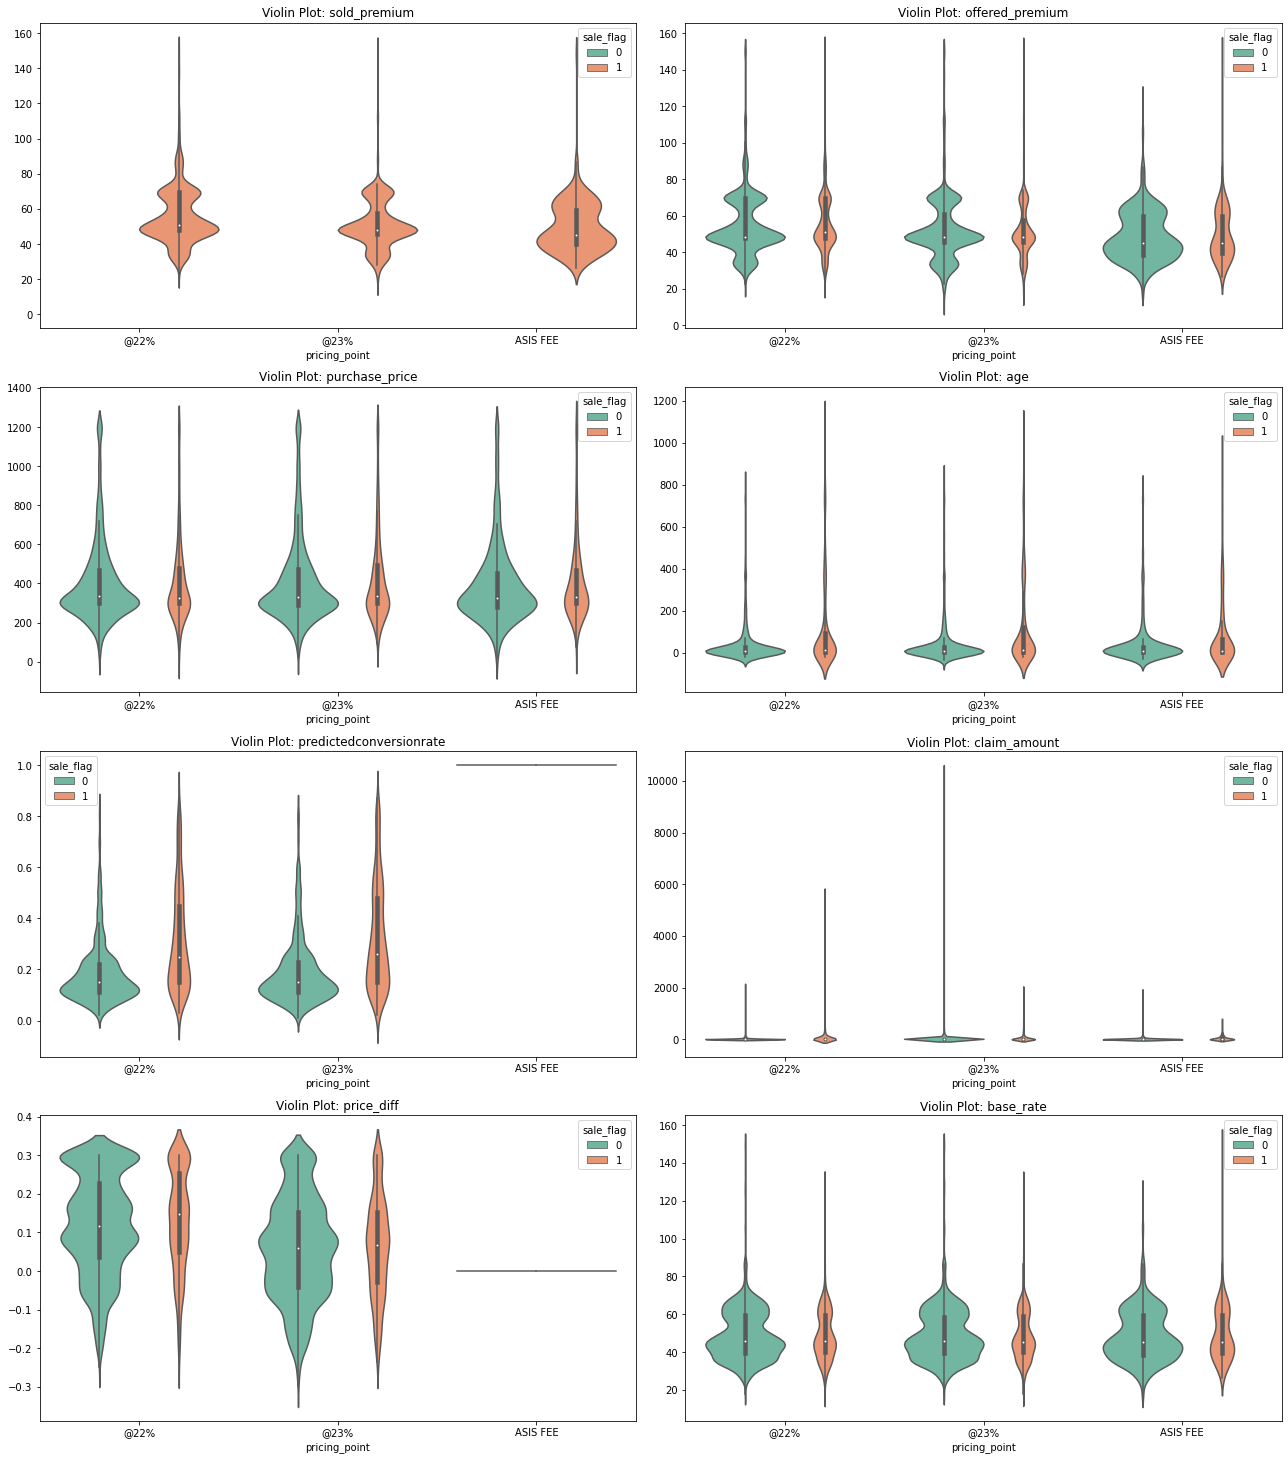

In [44]:
# Distribution of numeric variables vs target variables - sale_flag and pricing_point

#Select only continuous numeric columns
cont_numeric_columns = ['sold_premium', 'offered_premium', 'purchase_price', 'age', 'predictedconversionrate', 
                        'claim_amount','price_diff','base_rate']

# Set up the plot grid size 
n_cols = 2 
n_rows = (len(cont_numeric_columns) // n_cols) + 1

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten() 

# Loop through each numeric column and create a horizontal violin plot with count scaling
for i, col in enumerate(cont_numeric_columns):
    sns.violinplot(data=df_cl, x='pricing_point', y=col, hue='sale_flag',ax=axes[i], palette='Set2', orient='v', scale='count')  # Scale based on count
    axes[i].set_title(f'Violin Plot: {col}')
    axes[i].set_ylabel('')
    
# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

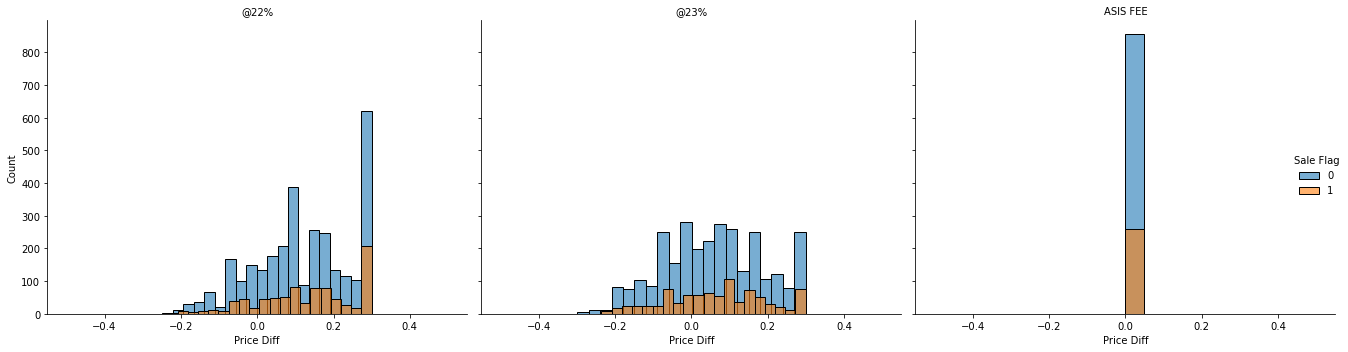

In [45]:
# price_diff vs sale_flag vs pricing_point:

# Create a FacetGrid with histograms for each pricing_point and sale_flag
g = sns.FacetGrid(df_cl, col="pricing_point", hue="sale_flag", height=5, aspect=1.2)
g.map(sns.histplot, "price_diff", kde=False, stat="count", alpha=0.6, bins=20)

# Add title and adjust layout
g.add_legend(title='Sale Flag')
g.set_axis_labels("Price Diff", "Count")
g.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.show()


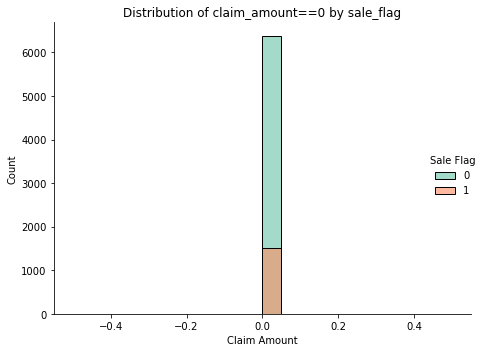

In [46]:
# Claim_amount by sale_flag: (with claim_amount == 0)

# filter claim_amount to 0:
df_filtered = df_cl[df_cl['claim_amount'] == 0]

# Create a FacetGrid with histograms for claim_amount based on pricing_point and sale_flag
g = sns.FacetGrid(df_filtered, hue="sale_flag", height=5, aspect=1.2, palette='Set2')
g.map(sns.histplot, "claim_amount", kde=False, stat="count", alpha=0.6, bins=20)

# Add title and adjust layout
g.add_legend(title='Sale Flag')
g.set_axis_labels("Claim Amount", "Count")
g.set_titles(col_template="{col_name}")
plt.title('Distribution of claim_amount==0 by sale_flag')
plt.tight_layout()
plt.show()

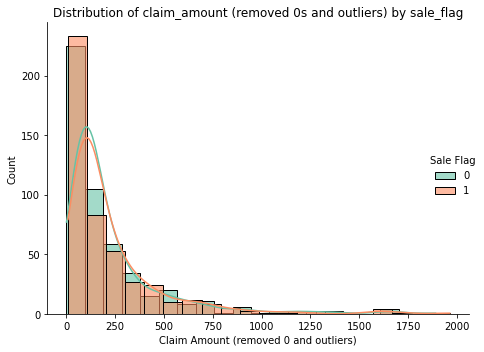

In [47]:
# Claim_amount by sale_flag: (with claim_amount > 0 & < 2000)

# Set a cutoff for claim amounts to remove 0s and exclude outliers
df_filtered = df_cl[(df_cl['claim_amount'] > 0) & (df_cl['claim_amount'] < 2000)]

# Create a FacetGrid with histograms for claim_amount based on pricing_point and sale_flag
g = sns.FacetGrid(df_filtered, hue="sale_flag", height=5, aspect=1.2, palette='Set2')
g.map(sns.histplot, "claim_amount", kde=True, stat="count", alpha=0.6, bins=20)

# Add title and adjust layout
g.add_legend(title='Sale Flag')
g.set_axis_labels("Claim Amount (removed 0 and outliers)", "Count")
g.set_titles(col_template="{col_name}")
plt.title('Distribution of claim_amount (removed 0s and outliers) by sale_flag')
plt.tight_layout()
plt.show()


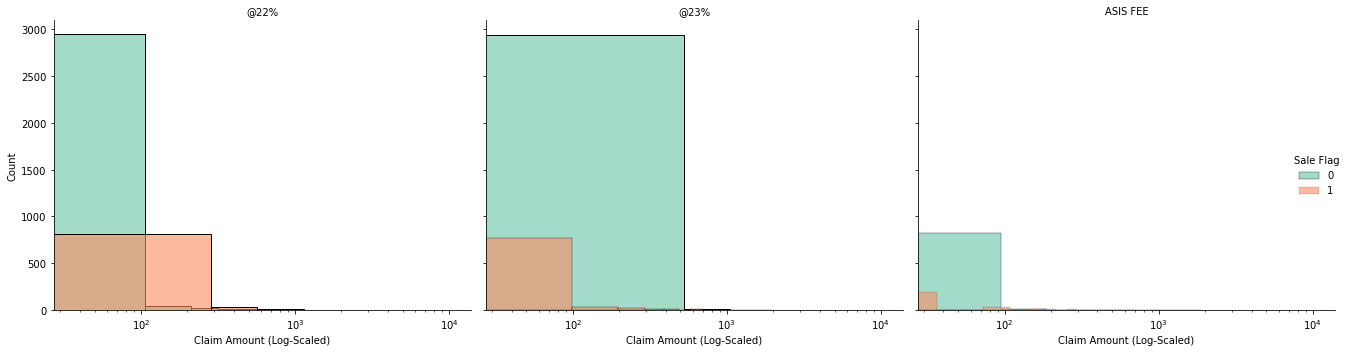

In [48]:
# (claim_amount vs sale_flag) vs pricing_point:

# Create a FacetGrid with histograms for claim_amount based on pricing_point and sale_flag
g = sns.FacetGrid(df_cl, col="pricing_point", hue="sale_flag", height=5, aspect=1.2, palette='Set2')
g.map(sns.histplot, "claim_amount", kde=False, stat="count", alpha=0.6, bins=20)

# Apply log scale to the x-axis
for ax in g.axes.flat:
    ax.set_xscale('log')

# Add title and adjust layout
g.add_legend(title='Sale Flag')
g.set_axis_labels("Claim Amount (Log-Scaled)", "Count")
g.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.show()


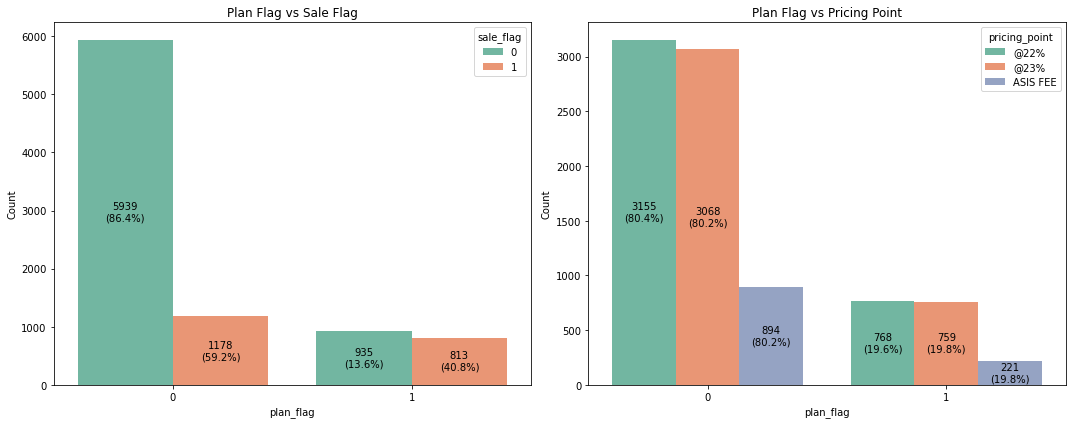

In [49]:
# Impact of (plan_flag on sale_flag) vs pricing_point:

# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Chart 1: Plan Flag vs Sale Flag
# Create a crosstab for plan_flag and sale_flag
plan_vs_sale = pd.crosstab(df_cl['plan_flag'], df_cl['sale_flag']).reset_index()

# Melt for plotting
plan_vs_sale_melt = pd.melt(plan_vs_sale, id_vars='plan_flag', value_vars=[0, 1], var_name='sale_flag', value_name='count')

# Plot the first bar chart
sns.barplot(x='plan_flag', y='count', hue='sale_flag', data=plan_vs_sale_melt, palette='Set2', ax=axes[0])
axes[0].set_title('Plan Flag vs Sale Flag')
axes[0].set_ylabel('Count')

# Annotate totals and percentages in the first chart
for container in axes[0].containers:
    # Get the total count for each plan_flag
    total = container.datavalues.sum()
    for bar in container:
        height = bar.get_height()
        percentage = (height / total) * 100
        # Annotate both count and percentage
        axes[0].annotate(f'{int(height)}\n({percentage:.1f}%)', 
                         (bar.get_x() + bar.get_width() / 2, height / 2),
                         ha='center', va='center', color='black', fontweight='light')

# Chart 2: Plan Flag vs Pricing Point
# Create a crosstab for plan_flag and pricing_point
plan_vs_pricing = pd.crosstab(df_cl['plan_flag'], df_cl['pricing_point']).reset_index()

# Melt for plotting
plan_vs_pricing_melt = pd.melt(plan_vs_pricing, id_vars='plan_flag', value_vars=['@22%', '@23%', 'ASIS FEE'], var_name='pricing_point', value_name='count')

# Plot the second bar chart
sns.barplot(x='plan_flag', y='count', hue='pricing_point', data=plan_vs_pricing_melt, palette='Set2', ax=axes[1])
axes[1].set_title('Plan Flag vs Pricing Point')
axes[1].set_ylabel('Count')

# Annotate totals and percentages in the second chart
for container in axes[1].containers:
    # Get the total count for each plan_flag
    total = container.datavalues.sum()
    for bar in container:
        height = bar.get_height()
        percentage = (height / total) * 100
        # Annotate both count and percentage
        axes[1].annotate(f'{int(height)}\n({percentage:.1f}%)', 
                         (bar.get_x() + bar.get_width() / 2, height / 2),
                         ha='center', va='center', color='black', fontweight='light')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


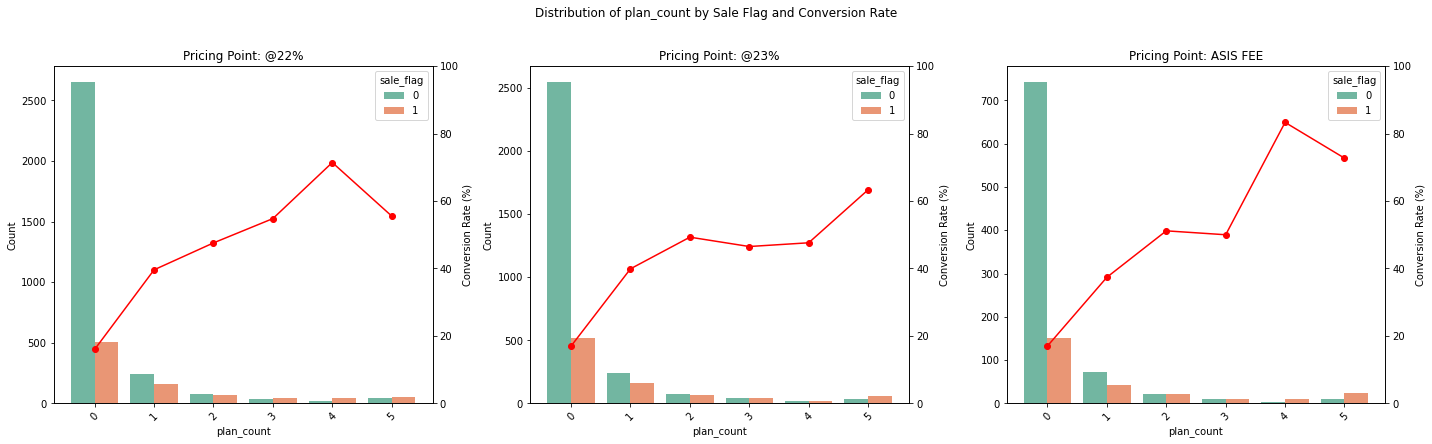

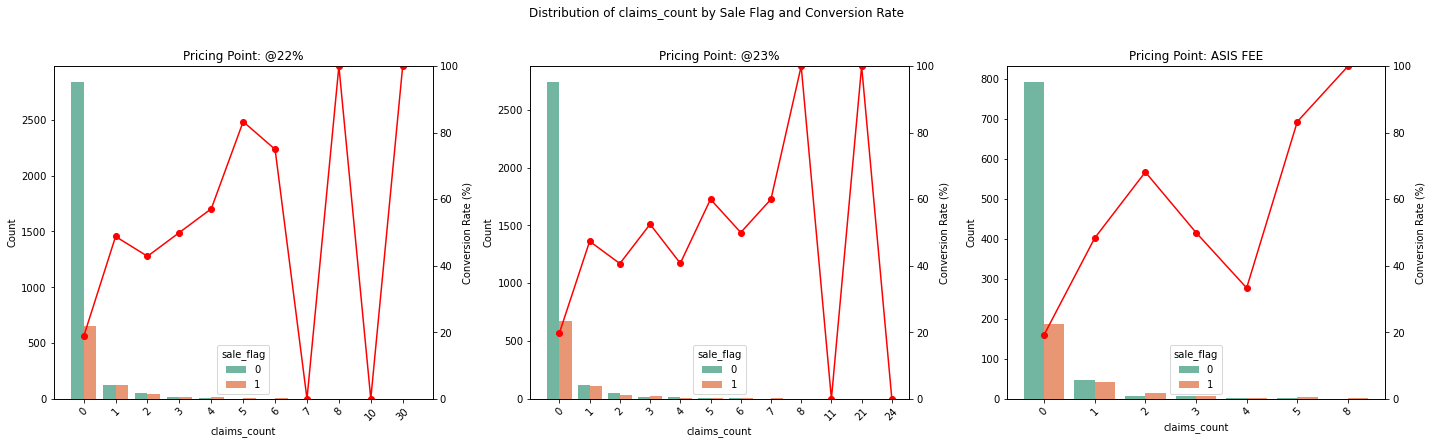

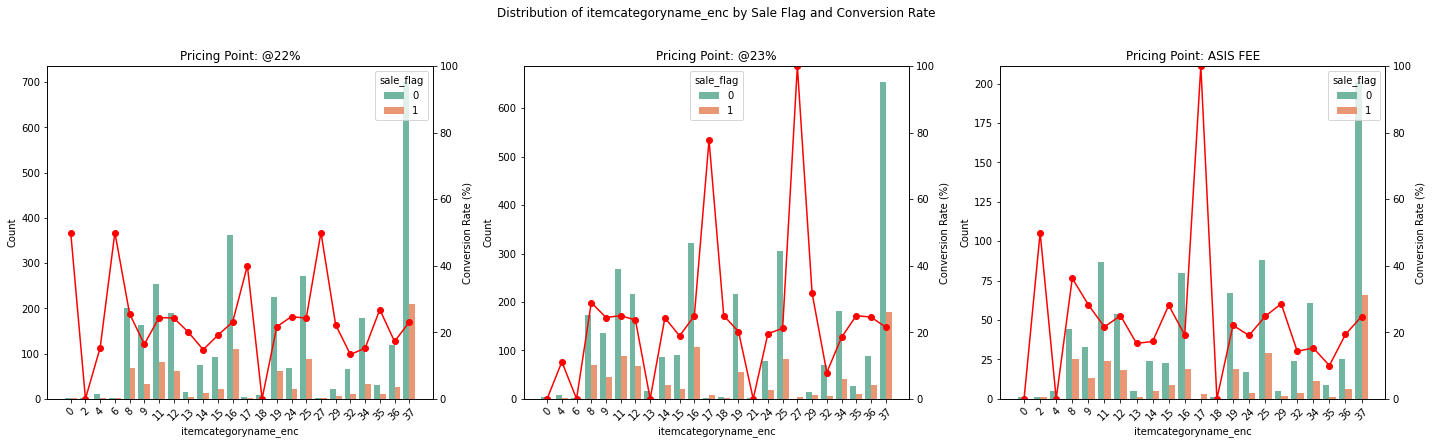

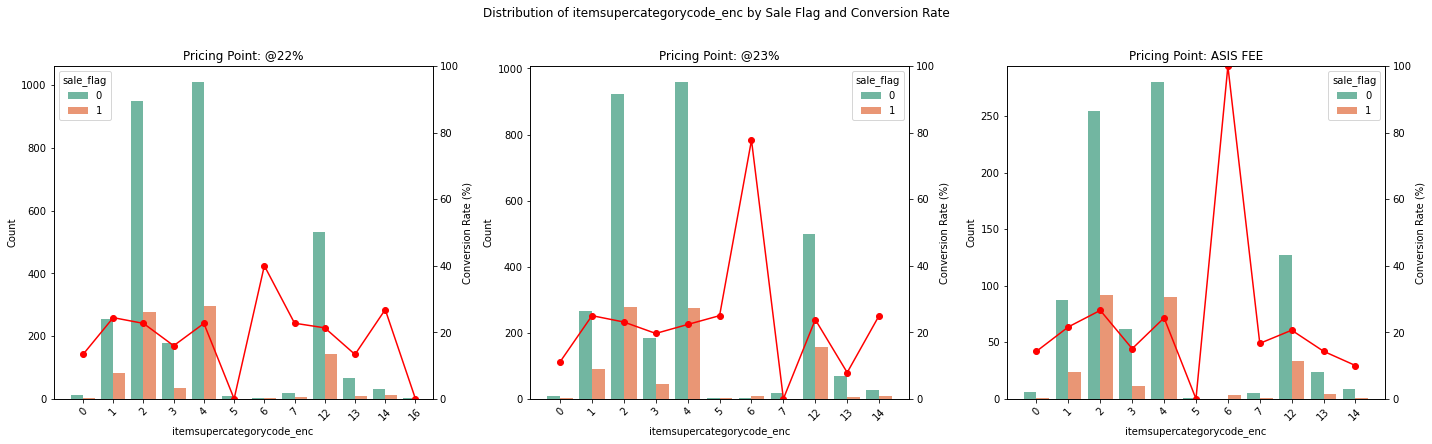

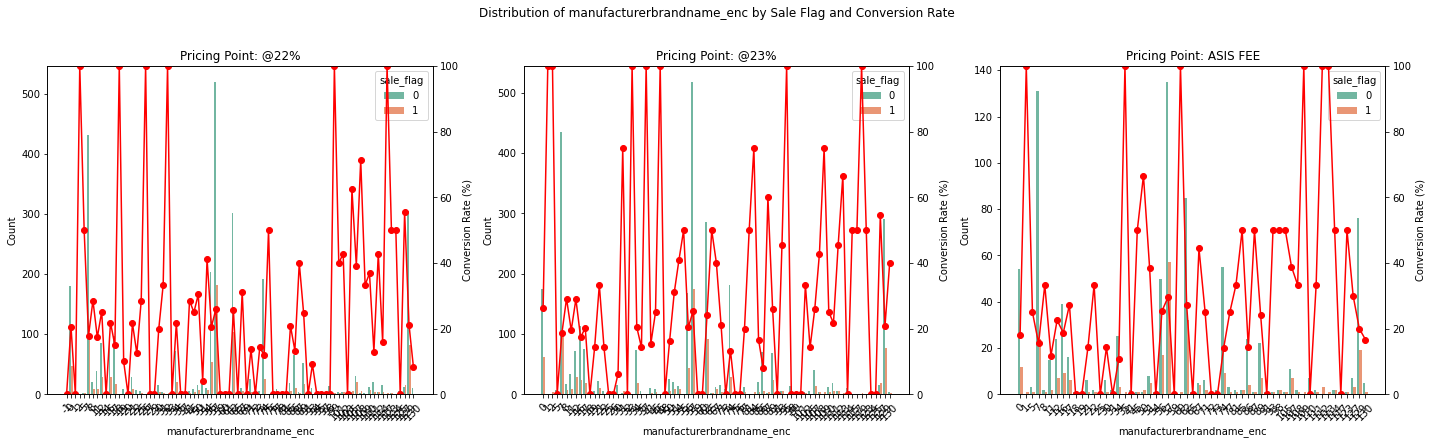

In [50]:
# cat variables vs sale_flag vs pricing_point: 

# List of categorical variables in your dataset
categorical_vars = ['plan_count', 'claims_count', 'itemcategoryname_enc', 'itemsupercategorycode_enc', 'manufacturerbrandname_enc']

def plot_sales_and_conversion(df_cl, categorical_vars):
    for var in categorical_vars:
        # Create figure with multiple subplots for each pricing point
        pricing_points = df_cl['pricing_point'].unique()
        fig, axes = plt.subplots(1, len(pricing_points), figsize=(20, 6))
        
        for idx, (ax, pricing_point) in enumerate(zip(axes, pricing_points)):
            # Filter data for current pricing point
            mask = df_cl['pricing_point'] == pricing_point
            data = df_cl[mask]
            
            # Calculate counts and conversion rates
            grouped = data.groupby(var).agg({
                'sale_flag': ['count', 'sum']
            }).reset_index()
            grouped.columns = [var, 'count', 'sales']
            grouped['conversion_rate'] = grouped['sales'] / grouped['count'] * 100
            
            # Create the bar plot
            sns.countplot(x=var, hue='sale_flag', data=data, ax=ax, palette='Set2')
            
            # Create secondary axis for conversion rate
            ax2 = ax.twinx()
            
            # Plot conversion rate line
            line = ax2.plot(range(len(grouped)), grouped['conversion_rate'], 
                          color='red', marker='o', label='Conversion Rate')
            
            # Set labels and titles
            ax.set_title(f'Pricing Point: {pricing_point}')
            ax.set_xlabel(var)
            ax.set_ylabel('Count')
            ax2.set_ylabel('Conversion Rate (%)')
            
            # Set conversion rate axis limits
            ax2.set_ylim(0, 100)
            
            # Rotate x-axis labels for better readability
            ax.tick_params(axis='x', rotation=45)
            
            # Ensure x-axis labels match the grouped data
            ax.set_xticks(range(len(grouped)))
            ax.set_xticklabels(grouped[var])
            
        plt.suptitle(f'Distribution of {var} by Sale Flag and Conversion Rate', y=1.02)
        plt.tight_layout()
        plt.show()

# Create the plots
plot_sales_and_conversion(df_cl, categorical_vars)

In [51]:
# predictedconversionrate vs actual conversion from sale_flag

# Filter data by pricing point for @22% and @23%
df_22 = df_cl[df_cl['pricing_point'] == '@22%']
df_23 = df_cl[df_cl['pricing_point'] == '@23%']

# Calculate the MAE and RMSE for @22% and @23%
mae_22 = mean_absolute_error(df_22['sale_flag'], df_22['predictedconversionrate'])
rmse_22 = np.sqrt(mean_squared_error(df_22['sale_flag'], df_22['predictedconversionrate']))

mae_23 = mean_absolute_error(df_23['sale_flag'], df_23['predictedconversionrate'])
rmse_23 = np.sqrt(mean_squared_error(df_23['sale_flag'], df_23['predictedconversionrate']))

# Create a summary table for the results
conversion_performance_summary = pd.DataFrame({
    'Pricing Point': ['@22%', '@23%'],
    'MAE': [mae_22, mae_23],
    'RMSE': [rmse_22, rmse_23]
})

conversion_performance_summary


,Pricing Point,MAE,RMSE
0,@22%,0.293128,0.385606
1,@23%,0.299752,0.391277


In [52]:
# We can't visulize like this for the entire datase, So, lets bin the dataset into 10 bins 
# and see how is the actual conversion against each bin of predicted conversion. 

# Define the bins for predicted conversion rates
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bin_labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

# Add a new column to the dataset with the binned predicted conversion rates
df_cl['predicted_conversion_bin'] = pd.cut(df_cl['predictedconversionrate'], bins, labels=bin_labels)

# Group the data by the predicted conversion bins and calculate the actual conversion rate for each bin
conversion_bin_analysis = df_cl.groupby('predicted_conversion_bin')['sale_flag'].mean().reset_index()
conversion_bin_analysis.columns = ['Predicted Conversion Bin', 'Actual Conversion Rate']

conversion_bin_analysis

C:\Users\deenu\AppData\Local\Temp\ipykernel_5712\2164886892.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cl['predicted_conversion_bin'] = pd.cut(df_cl['predictedconversionrate'], bins, labels=bin_labels)


,Predicted Conversion Bin,Actual Conversion Rate
0,0-10%,0.104000
1,10-20%,0.147862
2,20-30%,0.232980
3,30-40%,0.383051
4,40-50%,0.477690
5,50-60%,0.547619
6,60-70%,0.659341
7,70-80%,0.724138
8,80-90%,0.717391
9,90-100%,0.233184


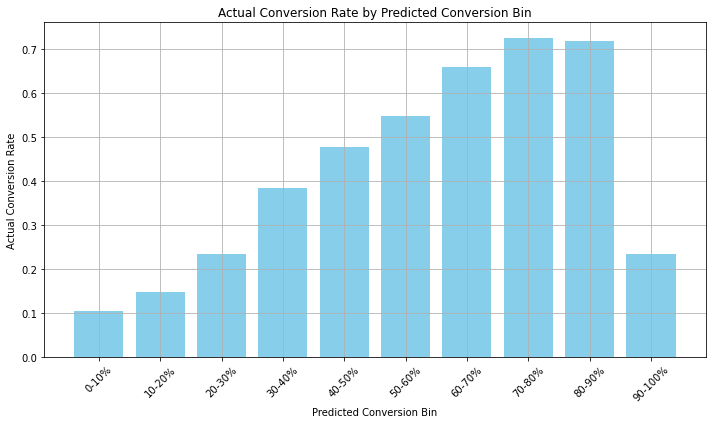

In [53]:
# To Visualise

# Plotting the actual conversion rates by predicted conversion bins
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar plot for actual conversion rates in each predicted conversion bin
ax.bar(conversion_bin_analysis['Predicted Conversion Bin'], conversion_bin_analysis['Actual Conversion Rate'], color='skyblue')

# Add labels and title
ax.set_xlabel('Predicted Conversion Bin')
ax.set_ylabel('Actual Conversion Rate')
ax.set_title('Actual Conversion Rate by Predicted Conversion Bin')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()

# Show the plot
plt.show()


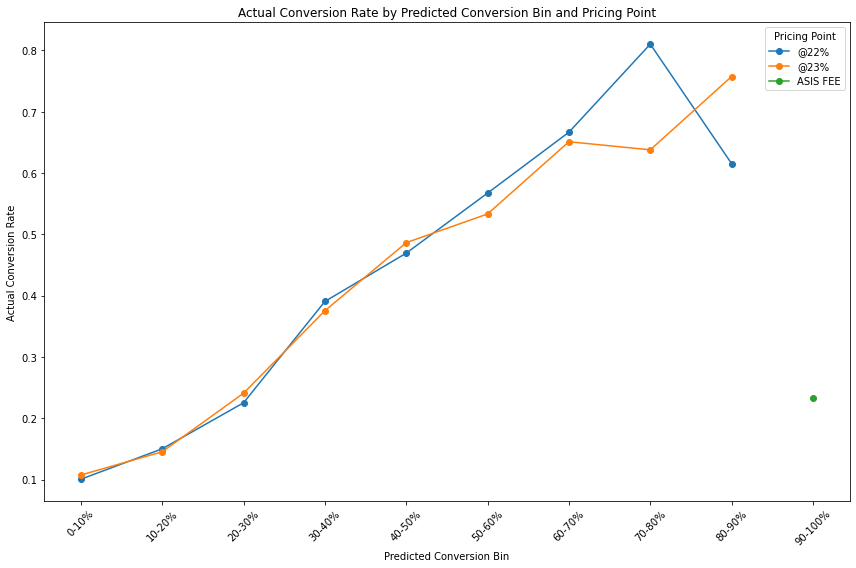

In [54]:
# (conversions pred vs actual) groupby pricing_point

# Group the data by both predicted conversion bins and pricing point, then calculate the actual conversion rate
conversion_bin_pricing_point_analysis = df_cl.groupby(['predicted_conversion_bin', 'pricing_point'])['sale_flag'].mean().unstack().reset_index()

# Plotting the actual conversion rates by predicted conversion bins for each pricing point
fig, ax = plt.subplots(figsize=(12, 8))

# Plot lines for each pricing point
for pricing_point in conversion_bin_pricing_point_analysis.columns[1:]:
    ax.plot(conversion_bin_pricing_point_analysis['predicted_conversion_bin'],
            conversion_bin_pricing_point_analysis[pricing_point], label=pricing_point, marker='o')

# Add labels and title
ax.set_xlabel('Predicted Conversion Bin')
ax.set_ylabel('Actual Conversion Rate')
ax.set_title('Actual Conversion Rate by Predicted Conversion Bin and Pricing Point')
ax.legend(title="Pricing Point")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


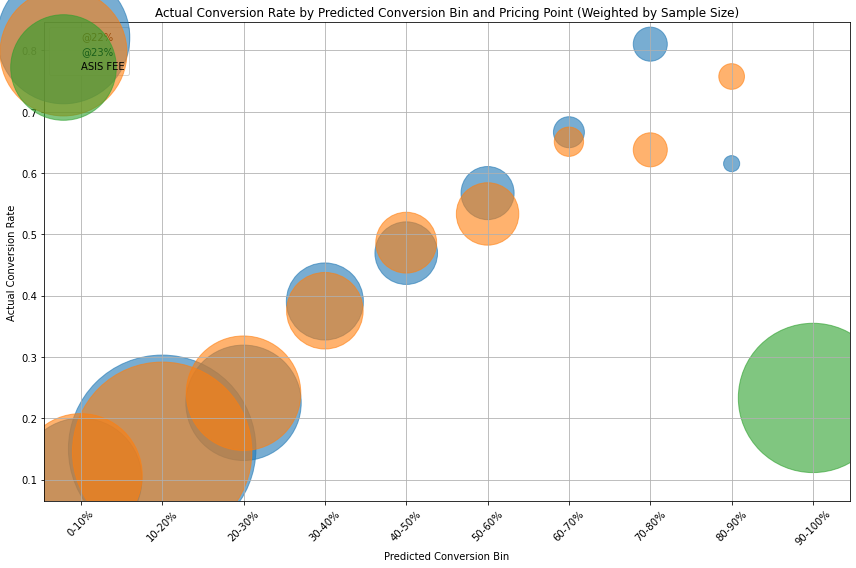

In [55]:
# (conversions pred vs actual) groupby pricing_point including the bin size

# Group the data by predicted conversion bins and pricing point to get the count (sample size) in each bin
conversion_bin_count = df_cl.groupby(['predicted_conversion_bin', 'pricing_point'])['sale_flag'].count().unstack().reset_index()

# Merging the actual conversion rate and count data for better understanding (fixing the column naming issue)
conversion_bin_merged = pd.merge(conversion_bin_pricing_point_analysis, conversion_bin_count, on='predicted_conversion_bin', suffixes=('_rate', '_count'))

# Correcting the column names for plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Define markersize scaling factor based on counts for better visibility
scaling_factor = 20

# Plot lines with varying marker sizes based on sample size
for pricing_point in ['@22%_rate', '@23%_rate', 'ASIS FEE_rate']:
    ax.scatter(conversion_bin_merged['predicted_conversion_bin'],
               conversion_bin_merged[pricing_point], 
               s=conversion_bin_merged[pricing_point.replace('_rate', '_count')] * scaling_factor, 
               label=pricing_point.replace('_rate', ''), alpha=0.6)

# Add labels and title
ax.set_xlabel('Predicted Conversion Bin')
ax.set_ylabel('Actual Conversion Rate')
ax.set_title('Actual Conversion Rate by Predicted Conversion Bin and Pricing Point (Weighted by Sample Size)')
ax.legend(title="Pricing Point")
ax.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()

# Show the plot
plt.show()


# 2.b Pricing performance of all strategies
b)	Compare the pricing performance of all strategies in a summary table with:
    a.	No of offers;
    b.	Average base, offered and sold premium
    c.	Average price increase
    d.	Conversion
    e.	How would you test (statistically) if they are different?


In [56]:
# Defining the strategy based on 'pricing_point'
# Group by 'pricing_point' to summarize the data for each strategy
summary_b = df.groupby('pricing_point').agg(
    num_offers=('pricing_point', 'count'),
    avg_base_rate=('base_rate', 'mean'),
    avg_offered_premium=('offered_premium', 'mean'),
    avg_sold_premium=('sold_premium', 'mean'),
    avg_price_increase=('price_diff', 'mean'),
    conversion_rate=('sale_flag', 'mean')
).reset_index()

summary_b

,pricing_point,num_offers,avg_base_rate,avg_offered_premium,avg_sold_premium,avg_price_increase,conversion_rate
0,@22%,3923,49.200958,55.212603,55.750694,0.124322,0.220240
1,@23%,3827,49.014236,51.976650,51.482768,0.059686,0.226548
2,ASIS FEE,1117,48.967628,48.967628,49.572923,0.000000,0.232766


In [57]:
# e. How would you test (statistically) if they are different?

# let us do statistical test for pricing_point vs sale_flag, offered_premium and sold_premium.
# pricing_point vs sale_flag - categorical variable vs categorical variable - chi squared test
# pricing_point vs offered_premium and sold_premium - cat vs numeric variable - ANOVA

In [58]:
# 1. Chi-squared test for pricing_point vs sale_flag

# Create a contingency table
contingency_table = pd.crosstab(df_cl['pricing_point'], df_cl['sale_flag'])

# Perform the chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculate Cramér's V
n = contingency_table.sum().sum()  # Total sample size
min_dim = min(contingency_table.shape) - 1  # The smaller dimension (number of categories minus 1)
cramers_v = np.sqrt(chi2 / (n * min_dim))

# Print the result
print(f"Chi-squared Test Statistic: {chi2:.4f}")
print(f"p-value: {p:}")
print(f"Cramér's V: {cramers_v:.4f}\n")


# 2. ANOVA for offered_premium across pricing strategies
model_offered = ols('offered_premium ~ C(pricing_point)', data=df_cl).fit()
anova_table_offered = sm.stats.anova_lm(model_offered, typ=2)

# Calculate eta-squared for offered_premium
ssb_offered = anova_table_offered['sum_sq'][0]  # Sum of squares between groups
sst_offered = sum(anova_table_offered['sum_sq'])  # Total sum of squares
eta_squared_offered = ssb_offered / sst_offered


# 3. ANOVA for sold_premium across pricing strategies (where sale_flag == 1)
model_sold = ols('sold_premium ~ C(pricing_point)', data=df_cl[df_cl['sale_flag'] == 1]).fit()
anova_table_sold = sm.stats.anova_lm(model_sold, typ=2)

# Calculate eta-squared for sold_premium
ssb_sold = anova_table_sold['sum_sq'][0]  # Sum of squares between groups
sst_sold = sum(anova_table_sold['sum_sq'])  # Total sum of squares
eta_squared_sold = ssb_sold / sst_sold

# Displaying the results
print(f"ANOVA for offered_premium:\n{anova_table_offered}\n")
print(f"Eta-squared for offered_premium: {eta_squared_offered:}\n")

print(f"ANOVA for sold_premium (where sale_flag == 1):\n{anova_table_sold}\n")
print(f"Eta-squared for sold_premium: {eta_squared_sold:}")

Chi-squared Test Statistic: 0.9835
p-value: 0.6115687388823854
Cramér's V: 0.0105

ANOVA for offered_premium:
                        sum_sq      df          F        PR(>F)
C(pricing_point)  4.128045e+04     2.0  79.322582  7.167385e-35
Residual          2.305947e+06  8862.0        NaN           NaN

Eta-squared for offered_premium: 0.017586897698555398

ANOVA for sold_premium (where sale_flag == 1):
                         sum_sq      df         F        PR(>F)
C(pricing_point)   11572.254663     2.0  25.96033  7.417970e-12
Residual          443092.257518  1988.0       NaN           NaN

Eta-squared for sold_premium: 0.025452293621716457


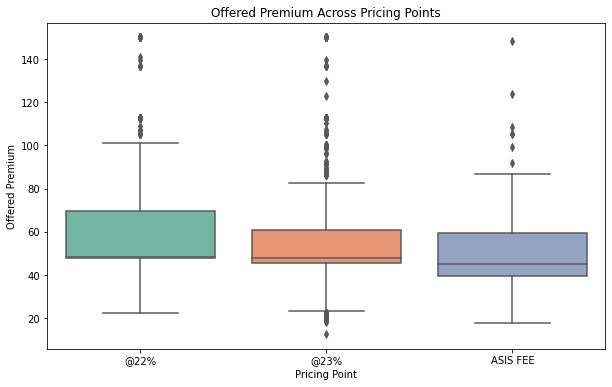

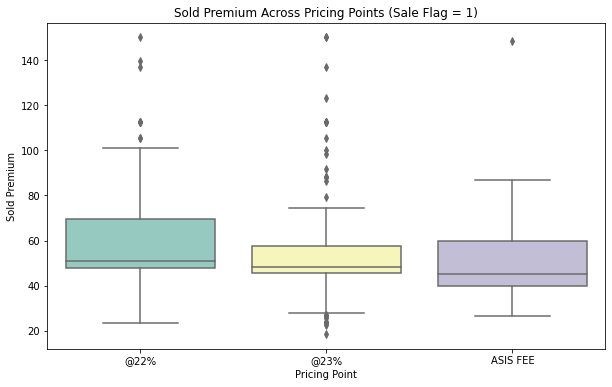

In [59]:
# Box plots for visualization of ANOVA results

# 1. Boxplot for Offered Premium across Pricing Points
plt.figure(figsize=(10, 6))
sns.boxplot(x='pricing_point', y='offered_premium', data=df_cl, palette='Set2')
plt.title('Offered Premium Across Pricing Points')
plt.ylabel('Offered Premium')
plt.xlabel('Pricing Point')
plt.show()

# 2. Boxplot for Sold Premium across Pricing Points (where sale_flag == 1)
plt.figure(figsize=(10, 6))
sns.boxplot(x='pricing_point', y='sold_premium', data=df_cl[df_cl['sale_flag'] == 1], palette='Set3')
plt.title('Sold Premium Across Pricing Points (Sale Flag = 1)')
plt.ylabel('Sold Premium')
plt.xlabel('Pricing Point')
plt.show()


In [60]:
# ANOVA is constrained by assumptions of normality and homogeneity of variance and can only test for differences in group means. 
# It also requires post-hoc tests to identify specific group differences and is sensitive to outliers.

# we are going for Kruskal-Wall which works on the median/rank.

In [61]:
# 1. Perform Kruskal-Wallis test for offered_premium
kruskal_offered_premium = kruskal(
    df_cl[df_cl['pricing_point'] == '@22%']['offered_premium'],
    df_cl[df_cl['pricing_point'] == '@23%']['offered_premium'],
    df_cl[df_cl['pricing_point'] == 'ASIS FEE']['offered_premium']
)

# 2. Perform Kruskal-Wallis test for sold_premium (where sale_flag == 1)
kruskal_sold_premium = kruskal(
    df_cl[(df_cl['pricing_point'] == '@22%') & (df_cl['sale_flag'] == 1)]['sold_premium'],
    df_cl[(df_cl['pricing_point'] == '@23%') & (df_cl['sale_flag'] == 1)]['sold_premium'],
    df_cl[(df_cl['pricing_point'] == 'ASIS FEE') & (df_cl['sale_flag'] == 1)]['sold_premium']
)

# Number of groups
k_offered = 3  # Three pricing strategies
k_sold = 3

# Sample sizes
n_offered = len(df_cl[df_cl['offered_premium'].notna()])
n_sold = len(df_cl[(df_cl['sale_flag'] == 1) & (df_cl['sold_premium'].notna())])

# Calculate Epsilon-squared for offered_premium
epsilon_squared_offered = (kruskal_offered_premium.statistic - k_offered + 1) / (n_offered - k_offered)

# Calculate Epsilon-squared for sold_premium
epsilon_squared_sold = (kruskal_sold_premium.statistic - k_sold + 1) / (n_sold - k_sold)

# Print the test results and effect sizes
print(f"Kruskal-Wallis Test for offered_premium:\nH-statistic: {kruskal_offered_premium.statistic:}, p-value: {kruskal_offered_premium.pvalue:}")
print(f"Epsilon-squared for offered_premium: {epsilon_squared_offered:}\n")

print(f"Kruskal-Wallis Test for sold_premium (where sale_flag == 1):\nH-statistic: {kruskal_sold_premium.statistic:}, p-value: {kruskal_sold_premium.pvalue:}")
print(f"Epsilon-squared for sold_premium: {epsilon_squared_sold:}")


Kruskal-Wallis Test for offered_premium:
H-statistic: 188.0328845960228, p-value: 1.4763111567166959e-41
Epsilon-squared for offered_premium: 0.020992200924850237

Kruskal-Wallis Test for sold_premium (where sale_flag == 1):
H-statistic: 61.660798172649685, p-value: 4.078756716346125e-14
Epsilon-squared for sold_premium: 0.03001046185746966


# 2.C Price Elasticity
	Compare the price elasticity of the strategies in the dataset: 
	Price elasticity
Δconversion/Δprice=  (((〖% conversion〗_(price point)-〖% conversion〗_(asis )))/〖% conversion〗_(asis ) )/(((〖£ avg premium〗_(price point)-〖£ avg premium〗_(asis )))/〖£ avg premium〗_(asis ) )
Note: this will give you the elasticity of one group versus other, would you be able to calculate the elasticity within a group?


In [62]:
# function to calculate price elasticity
def calculate_price_elasticity(conversion_rate, baseline_conversion_rate, avg_premium, baseline_avg_premium):
    
    conversion_diff = (conversion_rate - baseline_conversion_rate) / baseline_conversion_rate
    premium_diff = (avg_premium - baseline_avg_premium) / baseline_avg_premium
    
    # Handle the case where premium_diff is 0 to avoid division by zero
    if premium_diff != 0:
        return conversion_diff / premium_diff
    else:
        return None  # Return None if division by zero occurs

In [63]:
# Apply the price elasticity formula for different pricing points compared to ASIS FEE
price_ela_table = summary_b[['pricing_point', 'conversion_rate', 'avg_offered_premium']]
print (f"{price_ela_table}\n")

# Get baseline conversion rate and premium for ASIS FEE
asis_conversion_rate = price_ela_table[price_ela_table['pricing_point'] == 'ASIS FEE']['conversion_rate'].values[0]
asis_avg_premium = price_ela_table[price_ela_table['pricing_point'] == 'ASIS FEE']['avg_offered_premium'].values[0]

# Apply the price elasticity function for each pricing point
price_ela_table['price_elasticity'] = price_ela_table.apply(
    lambda row: calculate_price_elasticity(
        row['conversion_rate'], asis_conversion_rate, row['avg_offered_premium'], asis_avg_premium
    ),
    axis=1
)

print(price_ela_table[['pricing_point', 'price_elasticity']])

  pricing_point  conversion_rate  avg_offered_premium
0          @22%         0.220240            55.212603
1          @23%         0.226548            51.976650
2      ASIS FEE         0.232766            48.967628

  pricing_point  price_elasticity
0          @22%         -0.421984
1          @23%         -0.434734
2      ASIS FEE               NaN


C:\Users\deenu\AppData\Local\Temp\ipykernel_5712\1221820225.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_ela_table['price_elasticity'] = price_ela_table.apply(


In [64]:
price_ela_table

,pricing_point,conversion_rate,avg_offered_premium,price_elasticity
0,@22%,0.220240,55.212603,-0.421984
1,@23%,0.226548,51.976650,-0.434734
2,ASIS FEE,0.232766,48.967628,NaN


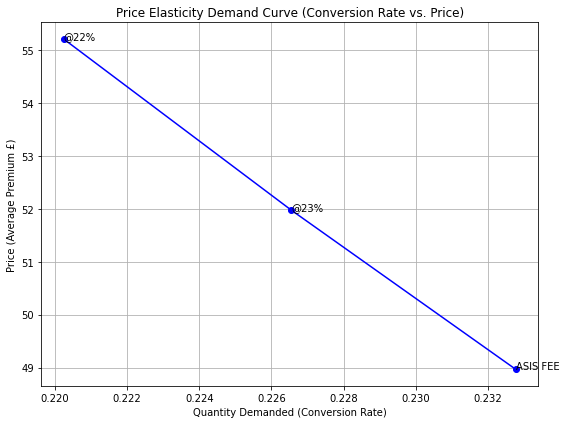

In [65]:
# Create a plot for the Price Elasticity Demand Curve
plt.figure(figsize=(8, 6))

# Plot the curve with the given data points
plt.plot(price_ela_table['conversion_rate'], price_ela_table['avg_offered_premium'], marker='o', linestyle='-', color='b')

# Annotate the graph to indicate the pricing points at different points
for i, label in enumerate(price_ela_table['pricing_point']):
    plt.annotate(label, (price_ela_table['conversion_rate'][i], price_ela_table['avg_offered_premium'][i]))

# Add labels and title
plt.title('Price Elasticity Demand Curve (Conversion Rate vs. Price)')
plt.xlabel('Quantity Demanded (Conversion Rate)')
plt.ylabel('Price (Average Premium £)')
plt.grid(True)

plt.tight_layout()
plt.show()


In [66]:
# would you be able to calculate the elasticity within a group?

## Yes, split the pricing_point (say @22) into subgroups (say 3 groups) based on the offered_premium (low, medium and high) 
## we can fix the low as baseline and find the price elasticity of medium and high with respect to low, which gives us a view within the group how conversion is behaving with price.

In [67]:
## Tried for @22 pricing point its successful, and extended the analysis to the other groups to see how they are.  

In [68]:
# Extended Analysis of price elasticity within the group for all three pricing_points individually:

# Function to perform the analysis for a given pricing point
def elasticity_analysis_for_pricing_point(data, pricing_point):
    # Filter the dataset for the specific pricing point
    data_filtered = data[data['pricing_point'] == pricing_point].copy()
    
    # Sort by offered premium and split into 3 groups (low, medium, high)
    data_filtered = data_filtered.sort_values(by='offered_premium')
    data_filtered['premium_group'] = pd.qcut(data_filtered['offered_premium'], q=3, labels=['low', 'medium', 'high'])
    
    # Calculate conversion rate and average offered premium for each group
    grouped_data = data_filtered.groupby('premium_group').agg(
        conversion_rate=('sale_flag', 'mean'),
        avg_offered_premium=('offered_premium', 'mean')
    ).reset_index()
    
    # Extract baseline (low) values
    conversion_low = grouped_data[grouped_data['premium_group'] == 'low']['conversion_rate'].values[0]
    premium_low = grouped_data[grouped_data['premium_group'] == 'low']['avg_offered_premium'].values[0]
    
    # Calculate price elasticity for medium and high groups compared to low (baseline)
    grouped_data['price_elasticity'] = grouped_data.apply(
        lambda row: calculate_price_elasticity(row['conversion_rate'], conversion_low, row['avg_offered_premium'], premium_low) 
        if row['premium_group'] != 'low' else None,
        axis=1
    )
    
    # Add pricing point as a label
    grouped_data['pricing_point'] = pricing_point
    
    return grouped_data[['premium_group', 'conversion_rate', 'avg_offered_premium', 'price_elasticity', 'pricing_point']]

# Perform the analysis for all pricing points: @22%, @23%, and ASIS FEE
pricing_points = ['@22%', '@23%', 'ASIS FEE']
all_results = []

# Loop through each pricing point and perform the analysis
for pricing_point in pricing_points:
    result = elasticity_analysis_for_pricing_point(df_cl, pricing_point)
    all_results.append(result)

# Concatenate results for all pricing points
Elasticity_withingroup_results = pd.concat(all_results, ignore_index=True)

# Pivot the results to display in the desired format (MultiIndex columns)
Elasticity_withingroup_table = Elasticity_withingroup_results.pivot(index='premium_group', columns='pricing_point', values=['conversion_rate', 'avg_offered_premium', 'price_elasticity'])

# Reorder the MultiIndex columns for a cleaner display
Elasticity_withingroup_table = Elasticity_withingroup_table.swaplevel(axis=1).sort_index(axis=1, level=0)
Elasticity_withingroup_table

pricing_point                @22%                                   \
              avg_offered_premium conversion_rate price_elasticity   
premium_group                                                        
low                     42.999865        0.199098              NaN   
medium                  51.870387        0.250879         1.260747   
high                    74.105505        0.228990         0.207550   

pricing_point                @23%                                   \
              avg_offered_premium conversion_rate price_elasticity   
premium_group                                                        
low                     39.252658        0.248630              NaN   
medium                  49.548500        0.207384        -0.632463   
high                    71.782925        0.219378        -0.141964   

pricing_point            ASIS FEE                                   
              avg_offered_premium conversion_rate price_elasticity  
premium_group                                                       
low                     35.571153        0.222520              NaN  
medium                  46.669178        0.225464         0.042407  
high                    65.050192        0.252055         0.160158

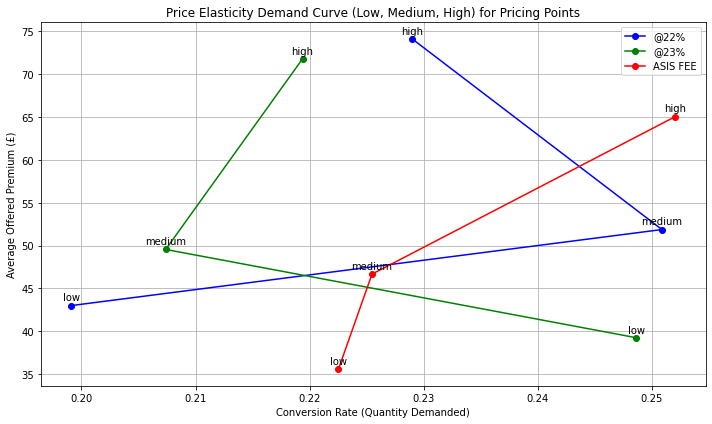

In [69]:
# Data extracted from your final table
premium_groups = ['low', 'medium', 'high']
avg_offered_premium_22 = [42.999865, 51.870387, 74.105505]
conversion_rate_22 = [0.199098, 0.250879, 0.228990]

avg_offered_premium_23 = [39.252658, 49.548500, 71.782925]
conversion_rate_23 = [0.248630, 0.207384, 0.219378]

avg_offered_premium_asis = [35.571153, 46.669178, 65.050192]
conversion_rate_asis = [0.222520, 0.225464, 0.252055]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot for @22%
plt.plot(conversion_rate_22, avg_offered_premium_22, marker='o', color='blue', linestyle='-', label='@22%')
for i, txt in enumerate(premium_groups):
    plt.annotate(txt, (conversion_rate_22[i], avg_offered_premium_22[i]), textcoords="offset points", xytext=(0, 5), ha='center')

# Plot for @23%
plt.plot(conversion_rate_23, avg_offered_premium_23, marker='o', color='green', linestyle='-', label='@23%')
for i, txt in enumerate(premium_groups):
    plt.annotate(txt, (conversion_rate_23[i], avg_offered_premium_23[i]), textcoords="offset points", xytext=(0, 5), ha='center')

# Plot for ASIS FEE
plt.plot(conversion_rate_asis, avg_offered_premium_asis, marker='o', color='red', linestyle='-', label='ASIS FEE')
for i, txt in enumerate(premium_groups):
    plt.annotate(txt, (conversion_rate_asis[i], avg_offered_premium_asis[i]), textcoords="offset points", xytext=(0, 5), ha='center')

# Set labels, title, and grid
plt.xlabel('Conversion Rate (Quantity Demanded)')
plt.ylabel('Average Offered Premium (£)')
plt.title('Price Elasticity Demand Curve (Low, Medium, High) for Pricing Points')
plt.grid(True)

plt.legend()
plt.tight_layout()
plt.show()

# 2.D Best Model (stastically and Revenue wise) 

d)	Assuming each pricing point is generated by a model at a different global constraint, would you be able to indicate: 
a.	which one is the best model from the statistical point of view? 
b.	and from pricing point of view (revenue)?


In [70]:
# Group by 'pricing_point' to summarize the data for each strategy
summary_d = df.groupby('pricing_point').agg(
    num_offers=('pricing_point', 'count'),
    avg_base_rate=('base_rate', 'mean'),
    avg_offered_premium=('offered_premium', 'mean'),
    avg_sold_premium=('sold_premium', 'mean'),
    avg_price_increase=('price_diff', 'mean'),
    conversion_rate=('sale_flag', 'mean'),
    orders_won=('sale_flag', 'sum'),
    total_sold_premium=('sold_premium', 'sum')
).reset_index()

summary_d

,pricing_point,num_offers,avg_base_rate,avg_offered_premium,avg_sold_premium,avg_price_increase,conversion_rate,orders_won,total_sold_premium
0,@22%,3923,49.200958,55.212603,55.750694,0.124322,0.220240,864,48168.60
1,@23%,3827,49.014236,51.976650,51.482768,0.059686,0.226548,867,44635.56
2,ASIS FEE,1117,48.967628,48.967628,49.572923,0.000000,0.232766,260,12888.96


In [71]:
# Please refer 2.B 1 for statistical test on pricing_point agianst the sale_flag and offered and sold premium

In [72]:
# b. and from pricing point of view (revenue)?
# Group by 'pricing_point' to summarize the data for each strategy
summary_d_b = df.groupby('pricing_point').agg(
    orders_won=('sale_flag', 'sum'),
    total_sold_premium=('sold_premium', 'sum')
).reset_index()

summary_d_b

,pricing_point,orders_won,total_sold_premium
0,@22%,864,48168.60
1,@23%,867,44635.56
2,ASIS FEE,260,12888.96


# 2.E Conversion vs Claims

e)	Claims frequency and value are provided, is there any direct relationship between conver-sion and claims?
a.	Would you say these models are biased?

C:\Users\deenu\AppData\Local\Temp\ipykernel_5712\3391419794.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cl['claims_category'] = df_cl['claims_count'].apply(categorize_claims)


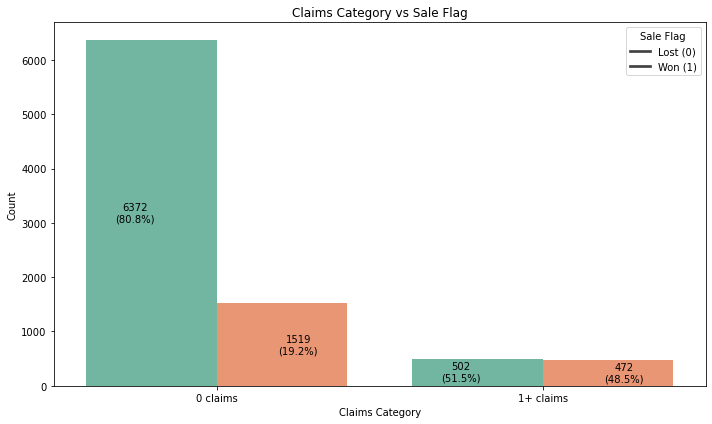


Percentages within each claims category:
sale_flag                0          1
claims_category                      
0 claims         80.750222  19.249778
1+ claims        51.540041  48.459959


In [73]:
# Define claims categorization function
def categorize_claims(count):
    if count == 0:
        return '0 claims'
    else:
        return '1+ claims'

# Create claims category
df_cl['claims_category'] = df_cl['claims_count'].apply(categorize_claims)

# Calculate counts and percentages
claims_sale_counts = pd.crosstab(df_cl['claims_category'], df_cl['sale_flag'])
claims_sale_pct = pd.crosstab(df_cl['claims_category'], df_cl['sale_flag'], normalize='index') * 100

# Create the plot
plt.figure(figsize=(10, 6))

# Prepare data for plotting
claims_vs_sale_melt = pd.melt(claims_sale_counts.reset_index(), 
                             id_vars='claims_category', 
                             value_vars=[0, 1], 
                             var_name='sale_flag', 
                             value_name='count')

# Create bar plot
ax = sns.barplot(x='claims_category', y='count', hue='sale_flag', 
                 data=claims_vs_sale_melt, palette='Set2')

# Annotate bars with counts and percentages
for claims_cat in claims_sale_counts.index:
    for sale_flag in [0, 1]:
        # Get count and percentage
        count = claims_sale_counts.loc[claims_cat, sale_flag]
        percentage = claims_sale_pct.loc[claims_cat, sale_flag]
        
        # Find the corresponding bar
        bar_idx = list(claims_sale_counts.index).index(claims_cat)
        x_pos = bar_idx + (0 if sale_flag == 0 else 0.5) - 0.25
        
        # Annotate
        plt.annotate(f'{count}\n({percentage:.1f}%)', 
                    xy=(x_pos, count/2),
                    ha='center', va='center',
                    color='black', fontweight='light')

# Customize the plot
plt.title('Claims Category vs Sale Flag')
plt.xlabel('Claims Category')
plt.ylabel('Count')

# Update legend labels
plt.legend(title='Sale Flag', labels=['Lost (0)', 'Won (1)'])

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print the actual percentages for verification
print("\nPercentages within each claims category:")
print(claims_sale_pct)

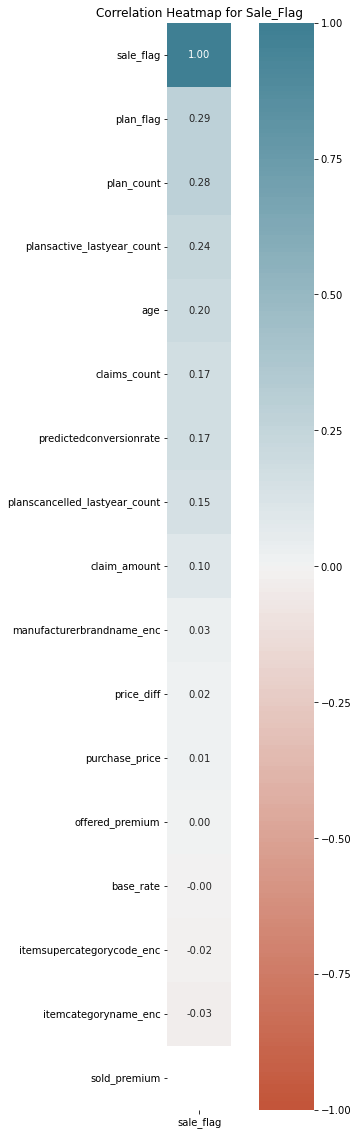

In [74]:
# Correlation Analysis for sale_flag:

# Reusing the dataset and computing correlations as per the user's request
corr1 = data.corr()
corr_sale_flag = corr1[['sale_flag']].sort_values(by='sale_flag', ascending=False)

# Creating the heatmap and adding annotations
plt.figure(figsize=(10, 20))
ax = sns.heatmap(
    corr_sale_flag,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt=".2f"   
)

# Display the plot
plt.title('Correlation Heatmap for Sale_Flag')
plt.show()


In [75]:
# a. Would you say these models are biased?

In [76]:
# Generating a summary table similar to 'summary_b', but focusing on claims_count
summary_claims_count = data.groupby('claims_count').agg(
    num_offers=('pricing_point', 'count'),
    avg_base_rate=('base_rate', 'mean'),
    avg_offered_premium=('offered_premium', 'mean'),
    avg_sold_premium=('sold_premium', 'mean'),
    avg_price_increase=('price_diff', 'mean'),
    conversion_rate=('sale_flag', 'mean'),
    orders_won=('sale_flag', 'sum'),
    total_sold_premium=('sold_premium', 'sum')
).reset_index()
summary_claims_count

,claims_count,num_offers,avg_base_rate,avg_offered_premium,avg_sold_premium,avg_price_increase,conversion_rate,orders_won,total_sold_premium
0,0.0,6930,48.756341,52.524952,51.968306,0.077701,0.177201,1228,63817.08
1,1.0,405,49.408691,53.815111,53.258010,0.093635,0.471605,191,10172.28
2,2.0,187,51.000642,56.097754,55.363373,0.100554,0.443850,83,4595.16
3,3.0,94,51.814894,56.069362,57.885000,0.075139,0.510638,48,2778.48
4,4.0,51,54.077647,58.981176,57.145000,0.096654,0.470588,24,1371.48
5,5.0,22,48.049091,53.274545,54.510000,0.122262,0.727273,16,872.16
6,6.0,14,45.111429,49.834286,50.346667,0.106023,0.642857,9,453.12
7,7.0,7,42.360000,46.851429,50.080000,0.114676,0.428571,3,150.24
8,8.0,3,56.160000,56.080000,56.080000,0.007714,1.000000,3,168.24
9,10.0,1,60.960000,69.720000,NaN,0.143701,0.000000,0,0.00


In [77]:
# First, find the largest group for itemcategoryname_enc and manufacturerbrandname_enc
largest_itemcategory = data['itemcategoryname_enc'].mode()[0]
largest_manufacturerbrand = data['manufacturerbrandname_enc'].mode()[0]

# Filter the dataset based on these largest groups
filtered_data = data[
    (data['itemcategoryname_enc'] == largest_itemcategory) &
    (data['manufacturerbrandname_enc'] == largest_manufacturerbrand)
]

# Generate the summary table with the given filters
summary_claims_count_filtered = filtered_data.groupby('claims_count').agg(
    claim_amount=('claim_amount', 'sum'),
    num_offers=('pricing_point', 'count'),
    avg_base_rate=('base_rate', 'mean'),
    avg_offered_premium=('offered_premium', 'mean'),
    avg_sold_premium=('sold_premium', 'mean'),
    orders_won=('sale_flag', 'sum'),
    total_sold_premium=('sold_premium', 'sum')
).reset_index()

summary_claims_count_filtered

,claims_count,claim_amount,num_offers,avg_base_rate,avg_offered_premium,avg_sold_premium,orders_won,total_sold_premium
0,0.0,0.00,462,62.855844,67.211169,68.046667,90,6124.20
1,1.0,4694.60,35,63.058286,65.763429,65.774118,17,1118.16
2,2.0,2754.40,9,62.546667,72.333333,73.632000,5,368.16
3,3.0,2009.97,4,65.640000,66.630000,68.700000,2,137.40
4,4.0,1096.15,3,66.320000,69.720000,69.720000,2,139.44
5,5.0,1092.99,2,61.620000,69.540000,69.540000,2,139.08
6,6.0,879.60,1,63.600000,69.000000,69.000000,1,69.00
